In [1]:
import jax
import joblib
import random
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from aging.behavior.bio_age_model import (
    fit_model,
    masked_xval,
    raise_dim,
    constrained_fit
)
from scipy.spatial.distance import pdist, squareform
from itertools import product

from tqdm.auto import tqdm
from toolz import reduce, valmap, keyfilter, pluck, drop, merge
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from toolz import sliding_window
from collections import defaultdict

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, ParameterGrid

In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig4-longv1-lab-comments", tight_layout=False)

In [3]:
def minmax(df):
    return (df - df.min()) / (df.max() - df.min())


def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)

    percentile_.__name__ = "q_{:0.02f}".format(n)
    return percentile_


def compute_classifier(df, seed=0):
    pipe = make_pipeline(
        StandardScaler(),
        SVC(kernel="linear", class_weight="balanced"),
    )

    preds = cross_val_predict(
        pipe,
        df[["beh_age"]],
        df["classes"],
        groups=df['mouse'],
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=seed),
    )
    return accuracy_score(df["classes"], preds), preds


def minimizer(corrs):
    return corrs['Death'].iloc[-11:].mean()


def bin_age(df, bins):
    return pd.cut(df.reset_index()['age'], bins, labels=False)

## Load the death predictor data

In [4]:
death_df = pd.read_csv('/home/wg41/code/ontogeny/notebooks/exploration/win/death-predictor/death-predictor-data.csv').ffill()
death_df['Death'] = pd.to_datetime(death_df['Death'])

death_map = death_df.set_index('id')[['Death']].drop('04_02')
death_map['death_rank'] = death_map['Death'].rank()

In [5]:
to_remove = [
    "e4f1076b",
    "3867c517",
    "60e82cb4",
]

def load_long_df2(n_bins: "Optional[int]" = 75):
    keep_syllables = np.loadtxt(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt",
        dtype=int,
    )
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[keep_syllables]
    mask = df.index.get_level_values("age") < 100
    df = df[mask].copy()

    masks = []
    for uuid in to_remove:
        m = df.reset_index()["uuid"].str.startswith(uuid)
        masks.append(m)
    mask = np.array(reduce(or_, masks), dtype=bool)
    df = df[~mask].copy()

    size_df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_mouse_area_df_v00.parquet"
    )
    mask = size_df.index.get_level_values("age") < 100
    size_df = size_df[mask].copy()
    age_cut = pd.cut(size_df.index.get_level_values("age"), 19)

    size_df.loc[size_df["quant_0.5"] == 0, "quant_0.5"] = np.nan
    sizes_col = size_df["quant_0.5"]
    sizes_col = (
        sizes_col.groupby("mouse")
        .apply(lambda df: df.sort_index(level="age").interpolate())
        .droplevel(0)
    )

    sizes_col = sizes_col.groupby(age_cut, observed=True).transform(zscore)
    sizes_col = sizes_col.fillna(0)
    sizes_col = sizes_col.loc[df.index]

    # make sure df matches sizes
    df = df.loc[sizes_col.index]

    if n_bins is not None:
        # subsample the dataset
        cut, bins = pd.cut(df.index.get_level_values("age"), n_bins, retbins=True)
        tmp_df = (
            df.reset_index()
            .groupby(["mouse", cut], observed=True)
            .first()
            .reset_index()
            .drop(columns=["level_1"])
            .set_index(["age", "mouse", "subject_name", "session_name", "uuid", "date"])
        )
        sizes_col = (
            sizes_col.reset_index().groupby(["mouse", cut], observed=True).first()
        )
        sizes_col = (
            sizes_col.reset_index()
            .drop(columns=["level_1"])
            .set_index(["age", "mouse", "subject_name", "session_name", "uuid", "date"])
        )
        sizes_col = sizes_col.loc[tmp_df.index, "quant_0.5"]
    else:
        tmp_df = df

    age = jnp.array(tmp_df.index.get_level_values("age"))
    syllable_counts_jax = jnp.array(tmp_df.astype(float))

    label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
    mouse_ids = label_encoder.fit_transform(
        sizes_col.index.get_level_values("mouse").to_numpy()[:, None]
    ).T

    sort_idx = np.argsort(syllable_counts_jax.sum(0))[::-1]

    return tmp_df, syllable_counts_jax, age, sizes_col, mouse_ids, sort_idx, label_encoder

### Make functions for plotting

In [6]:
def make_death_df(reset_df, min_age, max_age, n_classes=4):

    joined = reset_df[reset_df['age'].between(min_age, max_age)].merge(
        death_map.reset_index(), left_on="mouse", right_on="id"
    ).dropna(subset=["Death"])

    classes = pd.qcut(joined["Death"], n_classes, labels=False)
    joined['classes'] = classes
    return joined

def fit_classifier(data, n_fits=100, n_classes=4):
    accs = []
    for seed in range(n_fits):
        acc, p = compute_classifier(data, seed=seed)
        accs.append(acc)
    print("Observed fit")
    print(n_classes, round(np.log2(np.mean(accs) / (1 / n_classes)), 2))

    # shuffle
    shuffs = []
    for i in tqdm(range(100)):
        shuff_df = data.copy()
        shuff_df['beh_age'] = shuff_df['beh_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
        # shuffle ages within age chunks rather than across everything to remove individual biases
        acc, p = compute_classifier(shuff_df, seed=i)
        shuffs.append(acc)
    print("Shuffle fit")
    print(n_classes, round(np.log2(np.mean(shuffs) / (1 / n_classes)), 2))
    return accs, shuffs

def plot_model(accs, shuffs, name, n_classes=4):
    fig = figure(0.55, 1.3)
    ax = sns.boxplot(data=[accs, shuffs], palette=['#333', 'silver'], showfliers=False, showcaps=False)
    ax.axhline(1 / n_classes, color='k', ls='--')
    ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))
    ax.tick_params(axis='x', rotation=90)
    sns.despine()
    saver(fig, name)

## Fit to ontogeny, apply to longtogeny

In [7]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col

In [8]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df, sizes_col = read_male_ontogeny(keep_syllables)

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

In [9]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy()
}

age_sd = 0.16

hypparams = {
    "log_age": True,
    "min_age": 2,
    "max_age": 125,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.25,
    "n_opt_iter": 150,
    "log_scale_sd": True,
}

## Fit age + size model on male ontogeny data 

In [10]:
mdl = fit_model(features, hypparams, 2, return_loss_on_error=False)

if len(mdl) == 1:
    print(hypparams['n_opt_iter'] - np.isnan(mdl['loss']).sum())

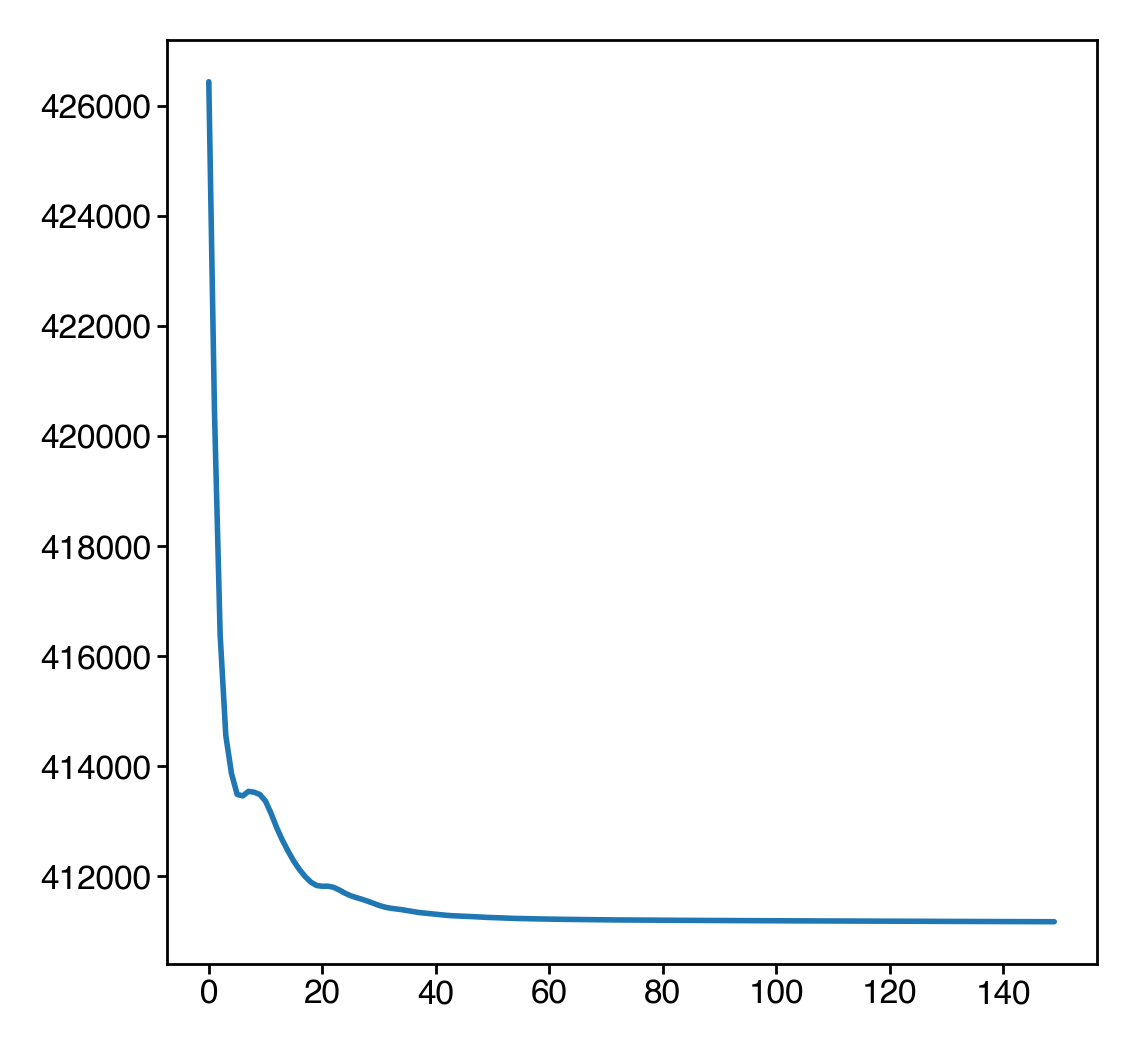

In [11]:
plt.plot(mdl['loss'])

## Fit a constrained model on wheel data

- Only fit the individuality parameter

In [12]:
(
    tmp_df,
    long_syllable_counts_jax,
    long_age,
    long_size_col,
    long_mouse_ids,
    sort_idx,
    long_labels,
) = load_long_df2(None)

In [13]:
long_features = {
    "ages": jnp.array(long_age, dtype=jnp.float32),  # models >= 1
    "counts": long_syllable_counts_jax + 1,  # models >= 1
    "sizes": jnp.array(long_size_col),
    "mice": jnp.array(long_mouse_ids),
}

long_hypparams = deepcopy(hypparams)
long_hypparams["n_animals"] = len(long_mouse_ids)
long_hypparams['n_opt_iter'] = 80

# this forces the identity factors to incorporate an experiment-specific
# syllable offset to account for "batch effects"
long_hypparams['zero_mean'] = False

In [14]:
fixed_params = mdl['params']

In [15]:
list(fixed_params)

['bio_basis_weights', 'size_slope']

In [16]:
long_mdl = constrained_fit(long_features, fixed_params, long_hypparams, 5, return_loss_on_error=False)

In [17]:
if len(long_mdl) == 1:
    print(long_hypparams['n_opt_iter'] - np.isnan(long_mdl['loss']).sum())

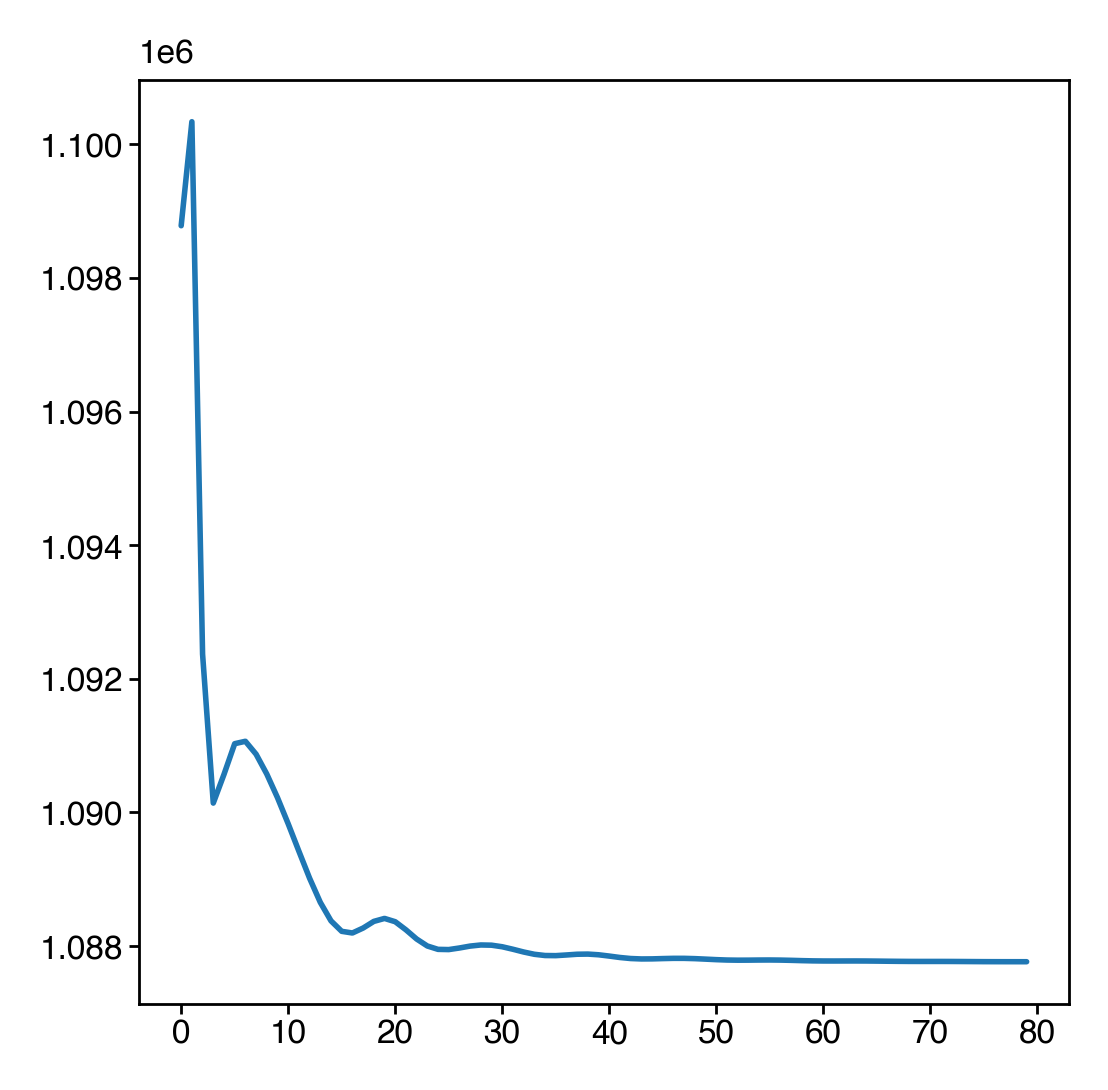

In [18]:
plt.plot(long_mdl['loss'])

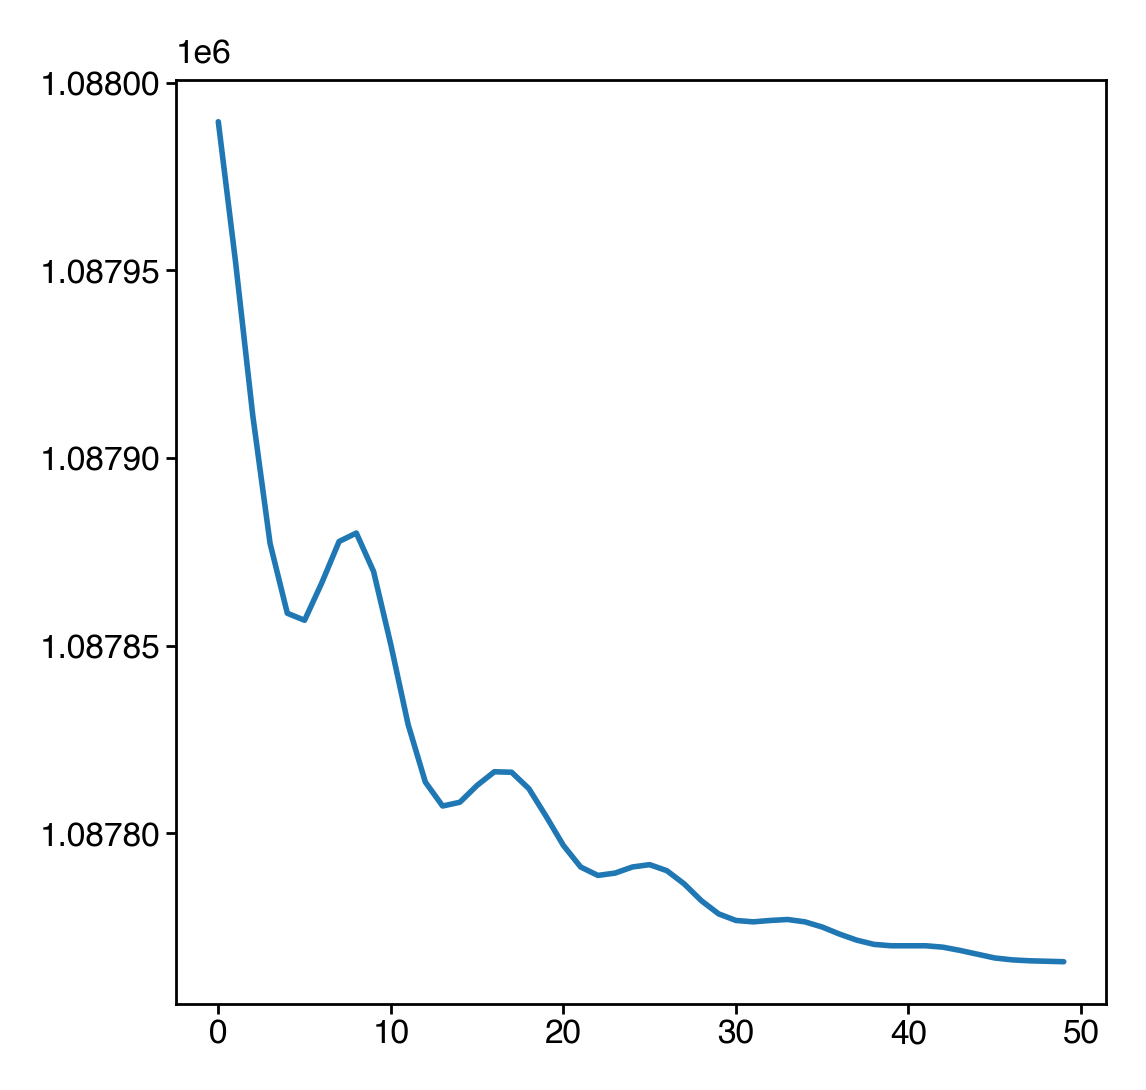

In [19]:
plt.plot(long_mdl['loss'][30:])

In [20]:
list(long_mdl['params'])

['development_weights', 'individual_biases', 'bio_basis_weights', 'size_slope']

In [21]:
ind_bias = raise_dim(long_mdl['params']['individual_biases'], axis=1)

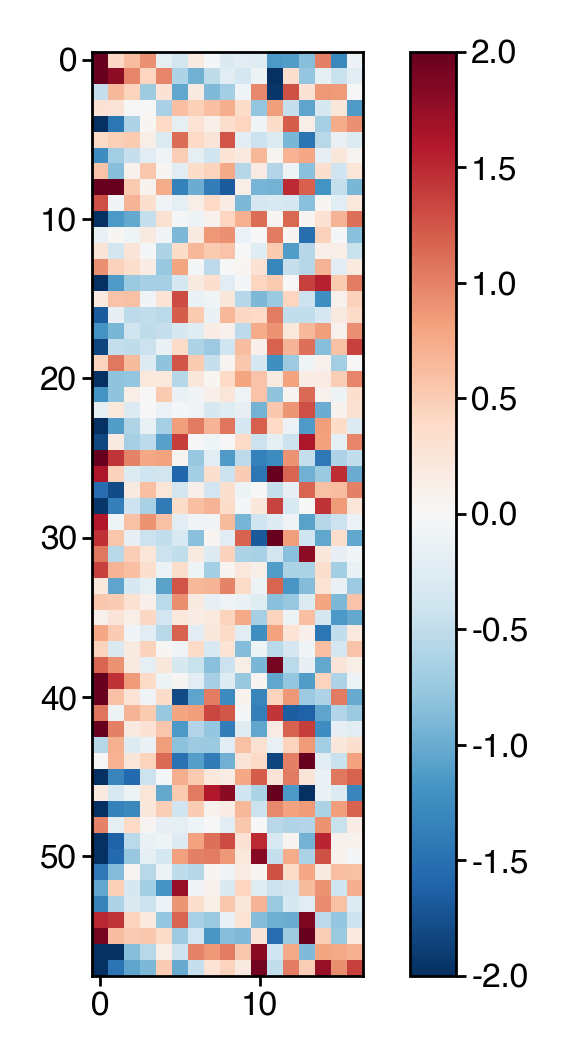

In [22]:
plt.imshow(ind_bias, cmap='RdBu_r', vmin=-2, vmax=2)
plt.colorbar()

<Axes: >

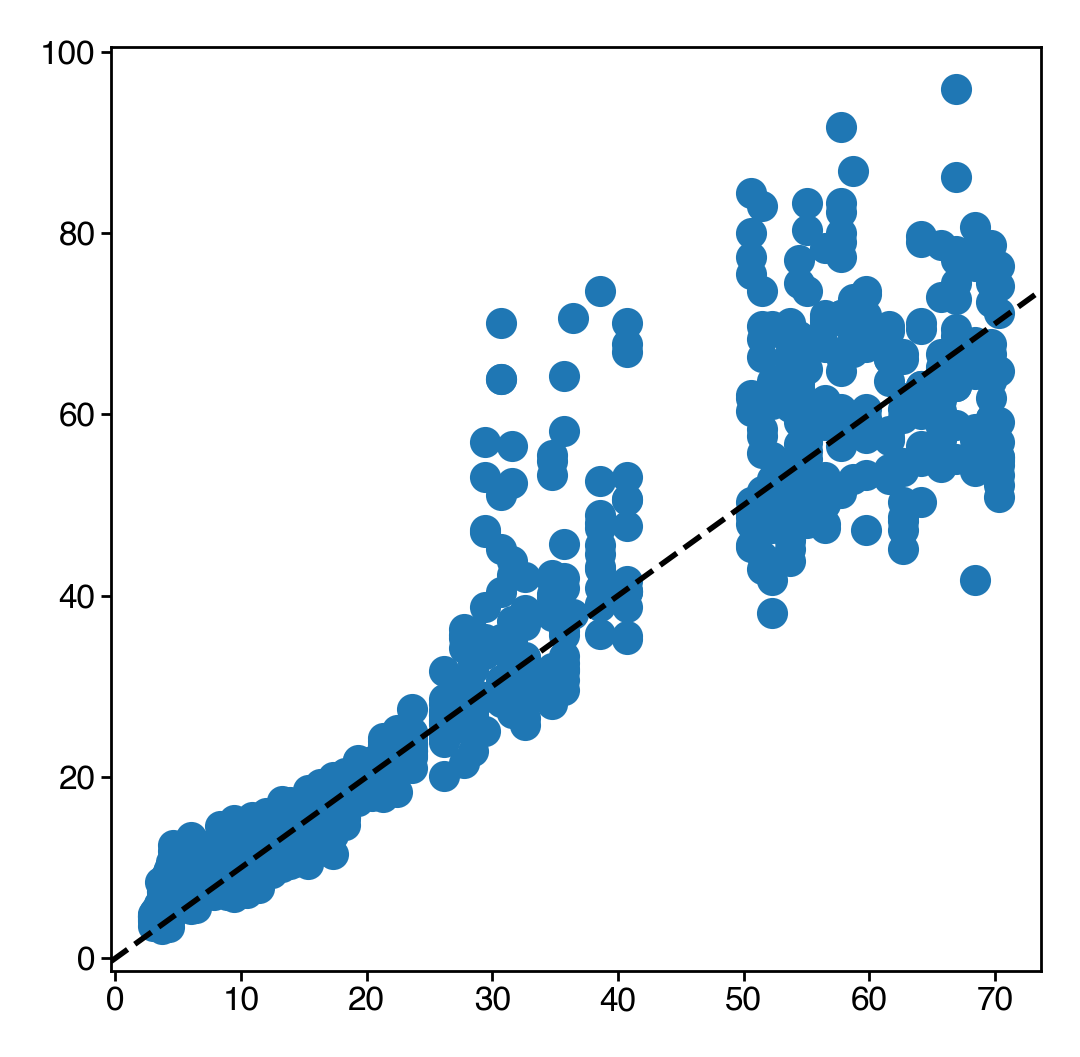

In [23]:
plt.scatter(long_mdl['true_ages'], long_mdl['bio_ages'])
add_identity(plt.gca(), color='k', ls='--')

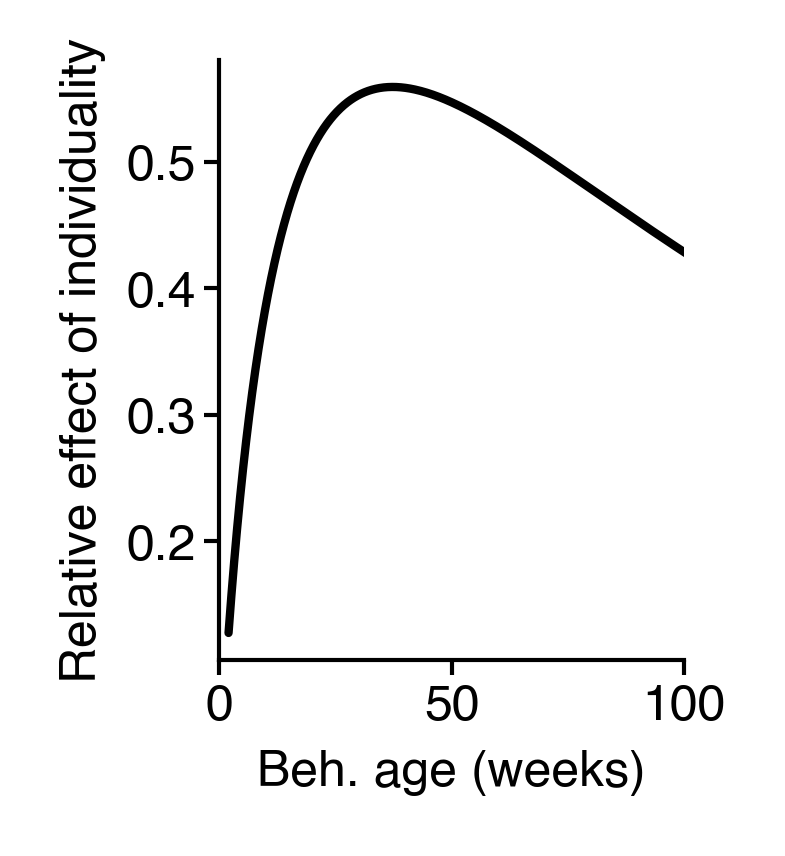

In [24]:
comps = long_mdl['init_components']

x = long_mdl['params']['development_weights']
dev = np.exp(x @ comps.bases['development']).squeeze()

fig = figure(1, 1.3)
ax = fig.gca()
ax.plot(comps.age_unnormalizer(comps.age_samples), dev, color='k')
plt.xlim(0, 100)
# plt.ylim(0, None)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of individuality")
sns.despine()

## Make dataframe

In [25]:
tmp_df['beh_age'] = long_mdl['bio_ages']

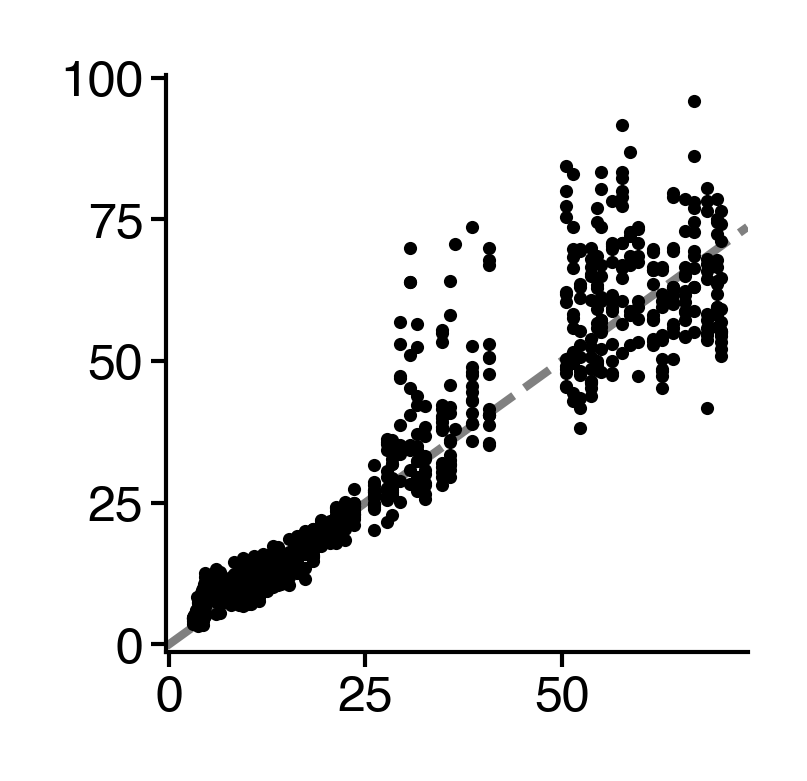

In [26]:
fig = figure(1.25, 1.25)
plt.scatter(long_mdl['true_ages'], long_mdl['bio_ages'], c='k', s=2.5, lw=0)
a = add_identity(plt.gca(), c='gray', ls='--', zorder=-1)
sns.despine()

## Join death and behavior

## Try classifying early/late death times 

Observed fit
4 0.4


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 -0.08


/tmp/ipykernel_44171/679344276.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))


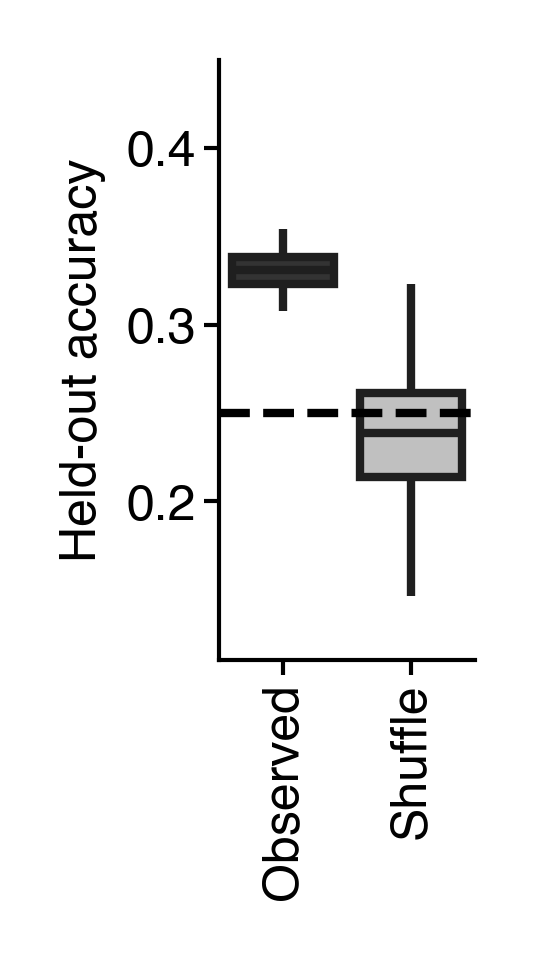

In [27]:
subset = make_death_df(tmp_df.reset_index(), 56, 71)
accs, shuffs = fit_classifier(subset)
plot_model(accs, shuffs, "tmp-death-rank-classifier-via-bambi")

In [28]:
subset[['classes', 'beh_age']].corr(method='spearman')

,classes,beh_age
classes,1.00000,-0.14569
beh_age,-0.14569,1.00000


In [29]:
subset[['death_rank', 'beh_age']].corr(method='spearman')

,death_rank,beh_age
death_rank,1.000000,-0.148025
beh_age,-0.148025,1.000000


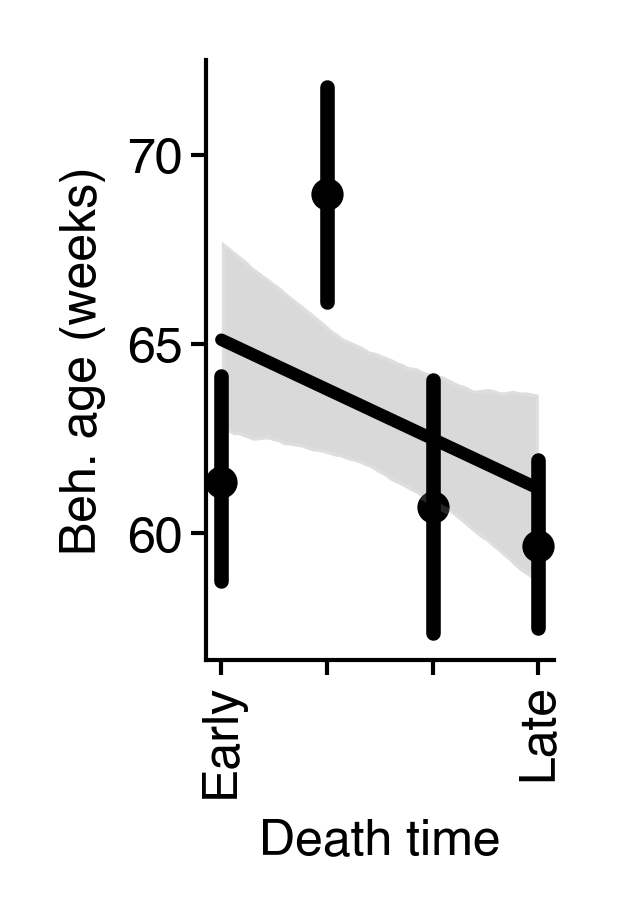

In [30]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset, x='classes', y='beh_age', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
# saver(fig, "bambi-beh-age-vs-death");

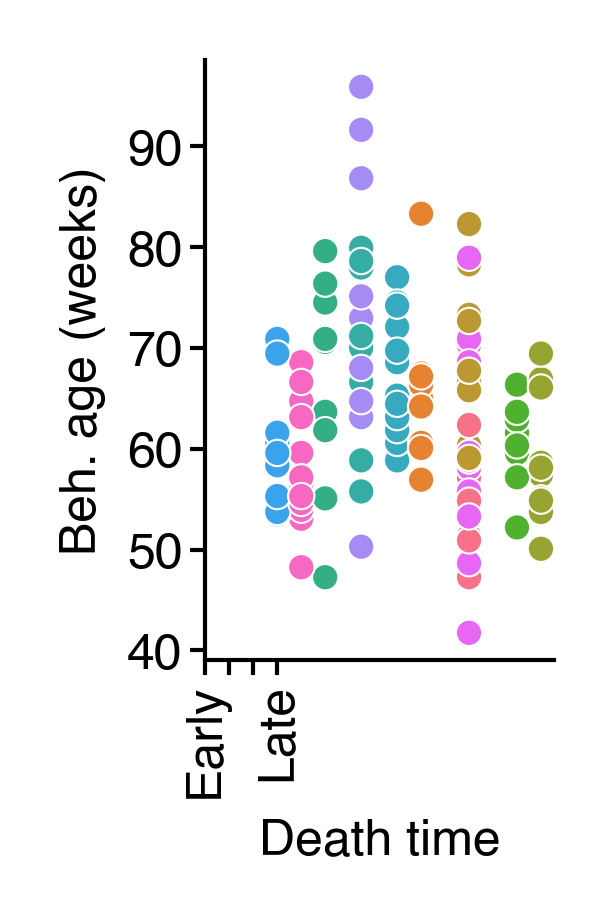

In [31]:
fig = figure(0.75, 1.3)
# ax = sns.regplot(data=subset, x='death_rank', y='beh_age', scatter=False)
ax = sns.scatterplot(data=subset, x='death_rank', y='beh_age', hue='mouse', legend=False, s=10)
# ax = sns.pointplot(data=subset, x='death_rank', y='beh_age', hue='mouse', legend=False)
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
# saver(fig, "bambi-beh-age-vs-death");

## Loop through different parameters

In [32]:
hypparams

{'log_age': True,
 'min_age': 2,
 'max_age': 125,
 'age_sd': 0.16,
 'n_age_samples': 1000,
 'n_splines': 4,
 'n_syllables': 58,
 'n_development_splines': 4,
 'scale': 150,
 'normalize_by_softmax': True,
 'n_keep_sylls': 25,
 'n_sessions': 333,
 'lr': 0.25,
 'n_opt_iter': 150,
 'log_scale_sd': True}

In [33]:
model_types = ['log-xform', 'log-xform-scale-sd', 'standard']

In [39]:
model_params = {
    'log-xform': {
        'log_age': True,
        'log_scale_sd': False,
    },
    'log-xform-scale-sd': {
        'log_age': True,
        'log_scale_sd': True,
    },
    'standard': {
        'log_age': False,
        'log_scale_sd': False,
    }
}

sd_ranges = {
    'log-xform': np.linspace(0.001, 0.05, 15), 
    'log-xform-scale-sd': np.linspace(0.05, 0.2, 25), 
    'standard': np.linspace(5, 13, 15),
}

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

log-xform 0.001 -0.01
log-xform 0.005 -0.02
log-xform 0.008 -0.03
log-xform 0.012 -0.05
log-xform 0.015 -0.08
log-xform 0.019 -0.14
log-xform 0.022 -0.18
log-xform 0.026 -0.17
log-xform 0.029 -0.15
log-xform 0.032 -0.14
log-xform 0.036 -0.12
log-xform 0.04 -0.1
log-xform 0.043 -0.09
log-xform 0.046 -0.08
log-xform 0.05 -0.08


  0%|          | 0/25 [00:00<?, ?it/s]

log-xform-scale-sd 0.05 -0.01
log-xform-scale-sd 0.056 -0.02
log-xform-scale-sd 0.062 -0.02
log-xform-scale-sd 0.069 -0.02
log-xform-scale-sd 0.075 -0.03
log-xform-scale-sd 0.081 -0.03
log-xform-scale-sd 0.088 -0.04
log-xform-scale-sd 0.094 -0.05
log-xform-scale-sd 0.1 -0.06
log-xform-scale-sd 0.106 -0.07
log-xform-scale-sd 0.113 -0.09
log-xform-scale-sd 0.119 -0.12
log-xform-scale-sd 0.125 -0.15
log-xform-scale-sd 0.131 -0.18
log-xform-scale-sd 0.138 -0.21
log-xform-scale-sd 0.144 -0.21
log-xform-scale-sd 0.15 -0.18
log-xform-scale-sd 0.156 -0.16
log-xform-scale-sd 0.163 -0.14
log-xform-scale-sd 0.169 -0.13
log-xform-scale-sd 0.175 -0.12
log-xform-scale-sd 0.181 -0.12
log-xform-scale-sd 0.188 -0.11
log-xform-scale-sd 0.194 -0.11
log-xform-scale-sd 0.2 -0.11


  0%|          | 0/15 [00:00<?, ?it/s]

standard 5.0 -0.1
standard 5.571 -0.08
standard 6.143 -0.07
standard 6.714 -0.14
standard 7.286 -0.14
standard 7.857 -0.14
standard 8.429 -0.14
standard 9.0 -0.13
standard 9.571 -0.13
standard 10.143 -0.12
standard 10.714 -0.12
standard 11.286 -0.12
standard 11.857 -0.12
standard 12.429 -0.12
standard 13.0 -0.12


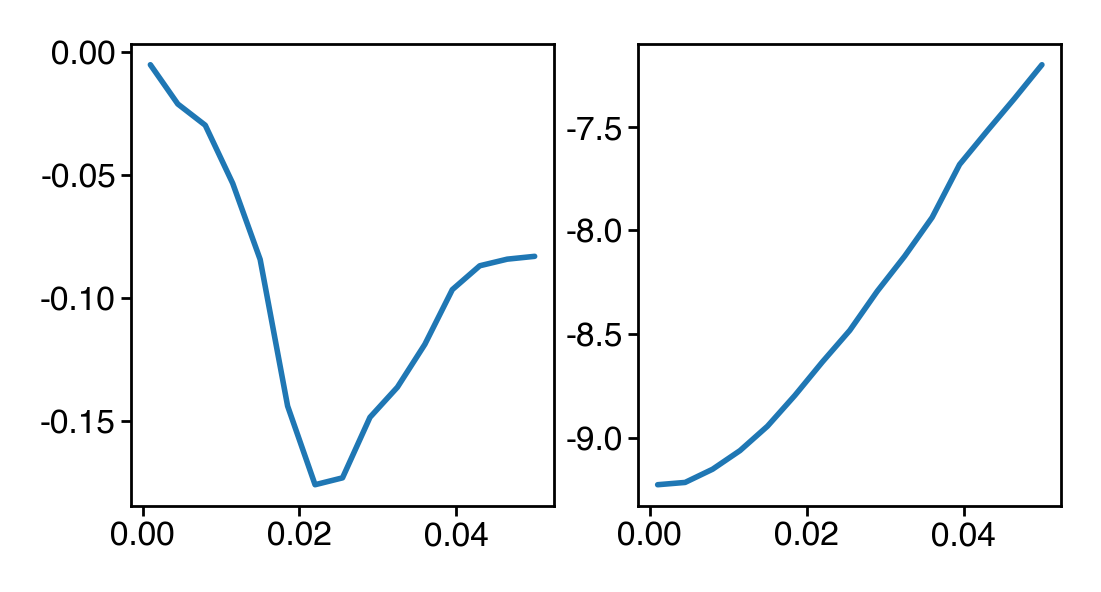

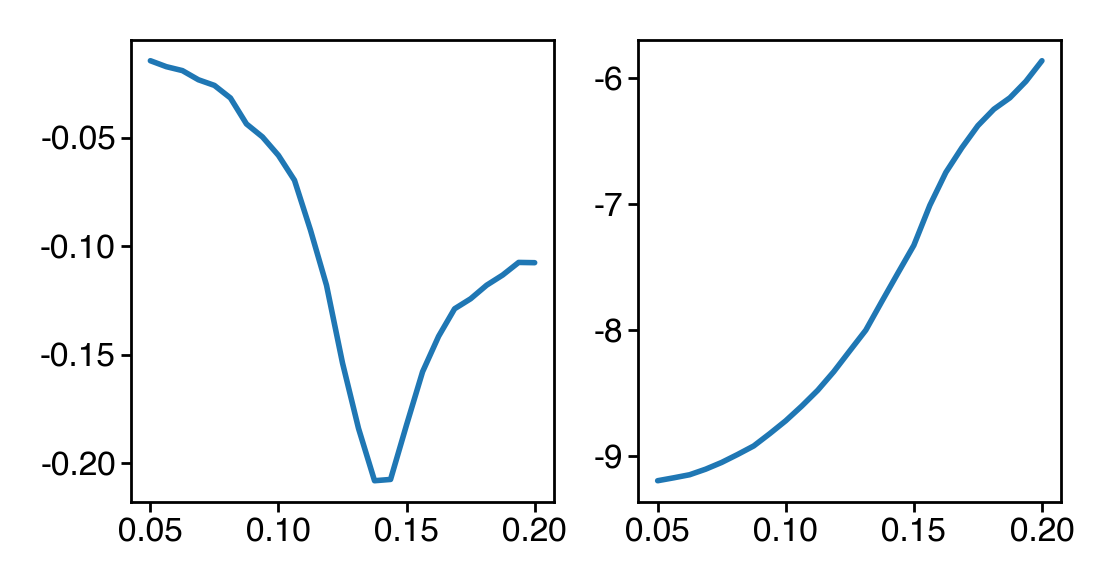

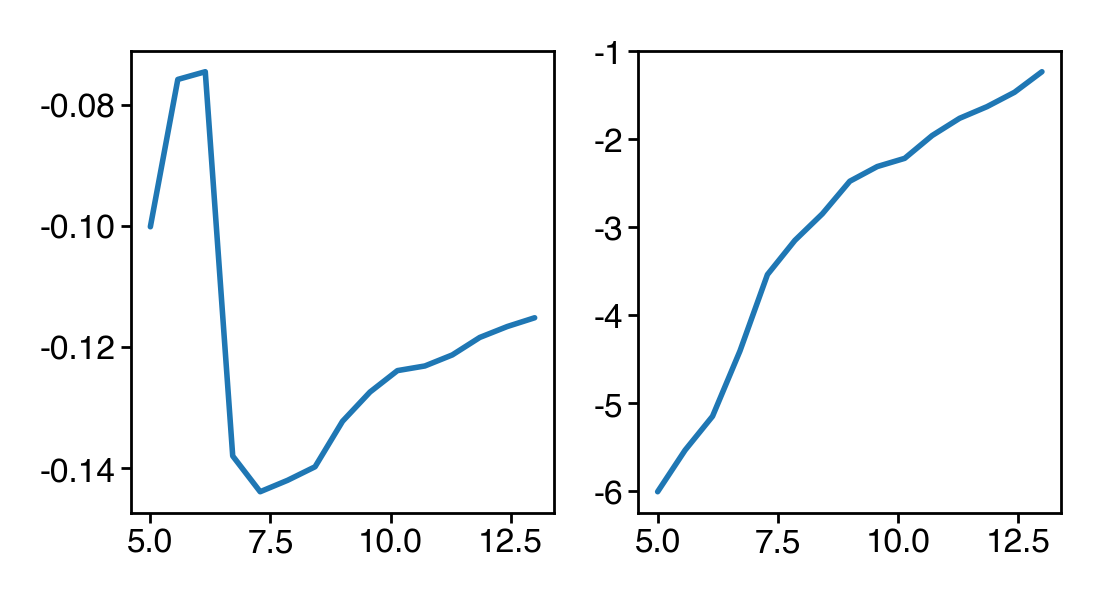

In [41]:
for m in tqdm(model_types):
    h_copy = deepcopy(hypparams)
    h_copy = merge(h_copy, model_params[m])

    residuals = []
    corrs = []

    for _sd in tqdm(sd_ranges[m]):
        h_copy['age_sd'] = float(_sd)

        mdl1 = fit_model(features, h_copy, 2)
    
        long_hypparams = deepcopy(h_copy)
        long_hypparams["n_animals"] = len(long_mouse_ids)
        long_hypparams['n_opt_iter'] = 80
        long_hypparams['zero_mean'] = False
    
        fixed_params = mdl1['params']
    
        long_mdl = constrained_fit(long_features, fixed_params, long_hypparams, 5, return_loss_on_error=False)

        residuals.append(np.median(np.abs(long_mdl['true_ages'] - long_mdl['bio_ages'])) - 9.244)

        tmp_df['beh_age'] = long_mdl['bio_ages']
        subset = make_death_df(tmp_df.reset_index(), 56, 71)
        
        c = subset[['death_rank', 'beh_age']].corr(method='spearman').iloc[0, 1]
        print(m, round(_sd, 3), round(c, 2))
        corrs.append(c)

    residuals = pd.Series(residuals, index=sd_ranges[m])
    corrs = pd.Series(corrs, index=sd_ranges[m])
    fig, ax = plt.subplots(1, 2, figsize=(3, 1.5))
    corrs.plot(ax=ax[0])
    residuals.plot(ax=ax[1])

In [ ]:
residuals.plot()

In [ ]:
corrs.plot()

In [57]:
stage1 = np.linspace(0.01, 0.17, 15)
stage2 = np.linspace(0.1, 0.25, 15)

In [58]:
m = 'log-xform-scale-sd'
h_copy = deepcopy(hypparams)
h_copy = merge(h_copy, model_params[m])

residuals = {}
corrs = {}

for _sd in tqdm(stage1):
    h_copy['age_sd'] = float(_sd)

    mdl1 = fit_model(features, h_copy, 2)

    long_hypparams = deepcopy(h_copy)
    long_hypparams["n_animals"] = len(long_mouse_ids)
    long_hypparams['n_opt_iter'] = 80
    long_hypparams['zero_mean'] = False

    fixed_params = mdl1['params']

    for _sd2 in tqdm(stage2):
        long_hypparams['age_sd'] = float(_sd2)

        long_mdl = constrained_fit(long_features, fixed_params, long_hypparams, 5, return_loss_on_error=False)

        _resid = long_mdl['true_ages'] - long_mdl['bio_ages']
        _resid = _resid[long_mdl['true_ages'] > 45]
    
        residuals[(_sd, _sd2)] = np.median(np.abs(_resid)) - 9.244
    
        tmp_df['beh_age'] = long_mdl['bio_ages']
        subset = make_death_df(tmp_df.reset_index(), 56, 71)
        
        c = subset[['death_rank', 'beh_age']].corr(method='spearman').iloc[0, 1]
        print(m, round(_sd, 3), round(_sd2, 3), round(c, 2))
        corrs[(_sd, _sd2)] = c

residuals = pd.Series(residuals)
corrs = pd.Series(corrs)
# fig, ax = plt.subplots(1, 2, figsize=(3, 1.5))
# corrs.plot(ax=ax[0])
# residuals.plot(ax=ax[1])

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.01 0.1 -0.05
log-xform-scale-sd 0.01 0.111 -0.07
log-xform-scale-sd 0.01 0.121 -0.1
log-xform-scale-sd 0.01 0.132 -0.14
log-xform-scale-sd 0.01 0.143 -0.18
log-xform-scale-sd 0.01 0.154 -0.19
log-xform-scale-sd 0.01 0.164 -0.21
log-xform-scale-sd 0.01 0.175 -0.21
log-xform-scale-sd 0.01 0.186 -0.2
log-xform-scale-sd 0.01 0.196 -0.19
log-xform-scale-sd 0.01 0.207 -0.18
log-xform-scale-sd 0.01 0.218 -0.17
log-xform-scale-sd 0.01 0.229 -0.16
log-xform-scale-sd 0.01 0.239 -0.15
log-xform-scale-sd 0.01 0.25 -0.15


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.021 0.1 -0.05
log-xform-scale-sd 0.021 0.111 -0.07
log-xform-scale-sd 0.021 0.121 -0.1
log-xform-scale-sd 0.021 0.132 -0.14
log-xform-scale-sd 0.021 0.143 -0.18
log-xform-scale-sd 0.021 0.154 -0.2
log-xform-scale-sd 0.021 0.164 -0.2
log-xform-scale-sd 0.021 0.175 -0.2
log-xform-scale-sd 0.021 0.186 -0.2
log-xform-scale-sd 0.021 0.196 -0.19
log-xform-scale-sd 0.021 0.207 -0.18
log-xform-scale-sd 0.021 0.218 -0.18
log-xform-scale-sd 0.021 0.229 -0.16
log-xform-scale-sd 0.021 0.239 -0.15
log-xform-scale-sd 0.021 0.25 -0.15


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.033 0.1 -0.05
log-xform-scale-sd 0.033 0.111 -0.07
log-xform-scale-sd 0.033 0.121 -0.1
log-xform-scale-sd 0.033 0.132 -0.14
log-xform-scale-sd 0.033 0.143 -0.17
log-xform-scale-sd 0.033 0.154 -0.2
log-xform-scale-sd 0.033 0.164 -0.21
log-xform-scale-sd 0.033 0.175 -0.2
log-xform-scale-sd 0.033 0.186 -0.2
log-xform-scale-sd 0.033 0.196 -0.19
log-xform-scale-sd 0.033 0.207 -0.18
log-xform-scale-sd 0.033 0.218 -0.17
log-xform-scale-sd 0.033 0.229 -0.16
log-xform-scale-sd 0.033 0.239 -0.15
log-xform-scale-sd 0.033 0.25 -0.15


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.044 0.1 -0.05
log-xform-scale-sd 0.044 0.111 -0.07
log-xform-scale-sd 0.044 0.121 -0.1
log-xform-scale-sd 0.044 0.132 -0.14
log-xform-scale-sd 0.044 0.143 -0.18
log-xform-scale-sd 0.044 0.154 -0.2
log-xform-scale-sd 0.044 0.164 -0.21
log-xform-scale-sd 0.044 0.175 -0.2
log-xform-scale-sd 0.044 0.186 -0.21
log-xform-scale-sd 0.044 0.196 -0.19
log-xform-scale-sd 0.044 0.207 -0.18
log-xform-scale-sd 0.044 0.218 -0.17
log-xform-scale-sd 0.044 0.229 -0.16
log-xform-scale-sd 0.044 0.239 -0.15
log-xform-scale-sd 0.044 0.25 -0.15


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.056 0.1 -0.05
log-xform-scale-sd 0.056 0.111 -0.07
log-xform-scale-sd 0.056 0.121 -0.1
log-xform-scale-sd 0.056 0.132 -0.14
log-xform-scale-sd 0.056 0.143 -0.18
log-xform-scale-sd 0.056 0.154 -0.2
log-xform-scale-sd 0.056 0.164 -0.21
log-xform-scale-sd 0.056 0.175 -0.2
log-xform-scale-sd 0.056 0.186 -0.2
log-xform-scale-sd 0.056 0.196 -0.19
log-xform-scale-sd 0.056 0.207 -0.18
log-xform-scale-sd 0.056 0.218 -0.18
log-xform-scale-sd 0.056 0.229 -0.16
log-xform-scale-sd 0.056 0.239 -0.15
log-xform-scale-sd 0.056 0.25 -0.15


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.067 0.1 -0.05
log-xform-scale-sd 0.067 0.111 -0.07
log-xform-scale-sd 0.067 0.121 -0.1
log-xform-scale-sd 0.067 0.132 -0.15
log-xform-scale-sd 0.067 0.143 -0.18
log-xform-scale-sd 0.067 0.154 -0.2
log-xform-scale-sd 0.067 0.164 -0.21
log-xform-scale-sd 0.067 0.175 -0.21
log-xform-scale-sd 0.067 0.186 -0.2
log-xform-scale-sd 0.067 0.196 -0.19
log-xform-scale-sd 0.067 0.207 -0.18
log-xform-scale-sd 0.067 0.218 -0.17
log-xform-scale-sd 0.067 0.229 -0.17
log-xform-scale-sd 0.067 0.239 -0.16
log-xform-scale-sd 0.067 0.25 -0.15


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.079 0.1 -0.05
log-xform-scale-sd 0.079 0.111 -0.07
log-xform-scale-sd 0.079 0.121 -0.1
log-xform-scale-sd 0.079 0.132 -0.14
log-xform-scale-sd 0.079 0.143 -0.19
log-xform-scale-sd 0.079 0.154 -0.2
log-xform-scale-sd 0.079 0.164 -0.21
log-xform-scale-sd 0.079 0.175 -0.2
log-xform-scale-sd 0.079 0.186 -0.21
log-xform-scale-sd 0.079 0.196 -0.19
log-xform-scale-sd 0.079 0.207 -0.18
log-xform-scale-sd 0.079 0.218 -0.18
log-xform-scale-sd 0.079 0.229 -0.17
log-xform-scale-sd 0.079 0.239 -0.16
log-xform-scale-sd 0.079 0.25 -0.15


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.09 0.1 -0.05
log-xform-scale-sd 0.09 0.111 -0.07
log-xform-scale-sd 0.09 0.121 -0.1
log-xform-scale-sd 0.09 0.132 -0.16
log-xform-scale-sd 0.09 0.143 -0.19
log-xform-scale-sd 0.09 0.154 -0.21
log-xform-scale-sd 0.09 0.164 -0.22
log-xform-scale-sd 0.09 0.175 -0.21
log-xform-scale-sd 0.09 0.186 -0.21
log-xform-scale-sd 0.09 0.196 -0.2
log-xform-scale-sd 0.09 0.207 -0.19
log-xform-scale-sd 0.09 0.218 -0.18
log-xform-scale-sd 0.09 0.229 -0.17
log-xform-scale-sd 0.09 0.239 -0.16
log-xform-scale-sd 0.09 0.25 -0.16


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.101 0.1 -0.06
log-xform-scale-sd 0.101 0.111 -0.08
log-xform-scale-sd 0.101 0.121 -0.11
log-xform-scale-sd 0.101 0.132 -0.16
log-xform-scale-sd 0.101 0.143 -0.19
log-xform-scale-sd 0.101 0.154 -0.22
log-xform-scale-sd 0.101 0.164 -0.22
log-xform-scale-sd 0.101 0.175 -0.22
log-xform-scale-sd 0.101 0.186 -0.21
log-xform-scale-sd 0.101 0.196 -0.2
log-xform-scale-sd 0.101 0.207 -0.19
log-xform-scale-sd 0.101 0.218 -0.18
log-xform-scale-sd 0.101 0.229 -0.17
log-xform-scale-sd 0.101 0.239 -0.17
log-xform-scale-sd 0.101 0.25 -0.16


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.113 0.1 -0.06
log-xform-scale-sd 0.113 0.111 -0.08
log-xform-scale-sd 0.113 0.121 -0.12
log-xform-scale-sd 0.113 0.132 -0.17
log-xform-scale-sd 0.113 0.143 -0.2
log-xform-scale-sd 0.113 0.154 -0.22
log-xform-scale-sd 0.113 0.164 -0.22
log-xform-scale-sd 0.113 0.175 -0.22
log-xform-scale-sd 0.113 0.186 -0.21
log-xform-scale-sd 0.113 0.196 -0.2
log-xform-scale-sd 0.113 0.207 -0.19
log-xform-scale-sd 0.113 0.218 -0.19
log-xform-scale-sd 0.113 0.229 -0.18
log-xform-scale-sd 0.113 0.239 -0.17
log-xform-scale-sd 0.113 0.25 -0.16


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.124 0.1 -0.07
log-xform-scale-sd 0.124 0.111 -0.09
log-xform-scale-sd 0.124 0.121 -0.14
log-xform-scale-sd 0.124 0.132 -0.18
log-xform-scale-sd 0.124 0.143 -0.21
log-xform-scale-sd 0.124 0.154 -0.23
log-xform-scale-sd 0.124 0.164 -0.22
log-xform-scale-sd 0.124 0.175 -0.22
log-xform-scale-sd 0.124 0.186 -0.21
log-xform-scale-sd 0.124 0.196 -0.2
log-xform-scale-sd 0.124 0.207 -0.19
log-xform-scale-sd 0.124 0.218 -0.19
log-xform-scale-sd 0.124 0.229 -0.18
log-xform-scale-sd 0.124 0.239 -0.17
log-xform-scale-sd 0.124 0.25 -0.16


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.136 0.1 -0.08
log-xform-scale-sd 0.136 0.111 -0.11
log-xform-scale-sd 0.136 0.121 -0.15
log-xform-scale-sd 0.136 0.132 -0.19
log-xform-scale-sd 0.136 0.143 -0.22
log-xform-scale-sd 0.136 0.154 -0.22
log-xform-scale-sd 0.136 0.164 -0.21
log-xform-scale-sd 0.136 0.175 -0.21
log-xform-scale-sd 0.136 0.186 -0.2
log-xform-scale-sd 0.136 0.196 -0.2
log-xform-scale-sd 0.136 0.207 -0.19
log-xform-scale-sd 0.136 0.218 -0.18
log-xform-scale-sd 0.136 0.229 -0.17
log-xform-scale-sd 0.136 0.239 -0.16
log-xform-scale-sd 0.136 0.25 -0.16


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.147 0.1 -0.09
log-xform-scale-sd 0.147 0.111 -0.12
log-xform-scale-sd 0.147 0.121 -0.16
log-xform-scale-sd 0.147 0.132 -0.19
log-xform-scale-sd 0.147 0.143 -0.2
log-xform-scale-sd 0.147 0.154 -0.19
log-xform-scale-sd 0.147 0.164 -0.18
log-xform-scale-sd 0.147 0.175 -0.17
log-xform-scale-sd 0.147 0.186 -0.16
log-xform-scale-sd 0.147 0.196 -0.16
log-xform-scale-sd 0.147 0.207 -0.15
log-xform-scale-sd 0.147 0.218 -0.15
log-xform-scale-sd 0.147 0.229 -0.14
log-xform-scale-sd 0.147 0.239 -0.14
log-xform-scale-sd 0.147 0.25 -0.14


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.159 0.1 -0.09
log-xform-scale-sd 0.159 0.111 -0.12
log-xform-scale-sd 0.159 0.121 -0.14
log-xform-scale-sd 0.159 0.132 -0.15
log-xform-scale-sd 0.159 0.143 -0.15
log-xform-scale-sd 0.159 0.154 -0.15
log-xform-scale-sd 0.159 0.164 -0.15
log-xform-scale-sd 0.159 0.175 -0.14
log-xform-scale-sd 0.159 0.186 -0.13
log-xform-scale-sd 0.159 0.196 -0.13
log-xform-scale-sd 0.159 0.207 -0.13
log-xform-scale-sd 0.159 0.218 -0.12
log-xform-scale-sd 0.159 0.229 -0.12
log-xform-scale-sd 0.159 0.239 -0.11
log-xform-scale-sd 0.159 0.25 -0.11


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.17 0.1 -0.09
log-xform-scale-sd 0.17 0.111 -0.11
log-xform-scale-sd 0.17 0.121 -0.12
log-xform-scale-sd 0.17 0.132 -0.14
log-xform-scale-sd 0.17 0.143 -0.14
log-xform-scale-sd 0.17 0.154 -0.14
log-xform-scale-sd 0.17 0.164 -0.13
log-xform-scale-sd 0.17 0.175 -0.13
log-xform-scale-sd 0.17 0.186 -0.12
log-xform-scale-sd 0.17 0.196 -0.12
log-xform-scale-sd 0.17 0.207 -0.12
log-xform-scale-sd 0.17 0.218 -0.11
log-xform-scale-sd 0.17 0.229 -0.11
log-xform-scale-sd 0.17 0.239 -0.1
log-xform-scale-sd 0.17 0.25 -0.1


In [59]:
# residuals = pd.Series(residuals)
# corrs = pd.Series(corrs)

In [60]:
corrs

0.01  0.100000   -0.048788
      0.110714   -0.068244
      0.121429   -0.097874
      0.132143   -0.143729
      0.142857   -0.177549
                    ...   
0.17  0.207143   -0.115072
      0.217857   -0.112066
      0.228571   -0.108105
      0.239286   -0.104961
      0.250000   -0.102751
Length: 225, dtype: float64

In [61]:
corrs.index.names = ['stage1', 'stage2']
residuals.index.names = ['stage1', 'stage2']

In [ ]:
corrs = corrs.reset_index()
residuals = residuals.reset_index()

<Axes: xlabel='stage2', ylabel='stage1'>

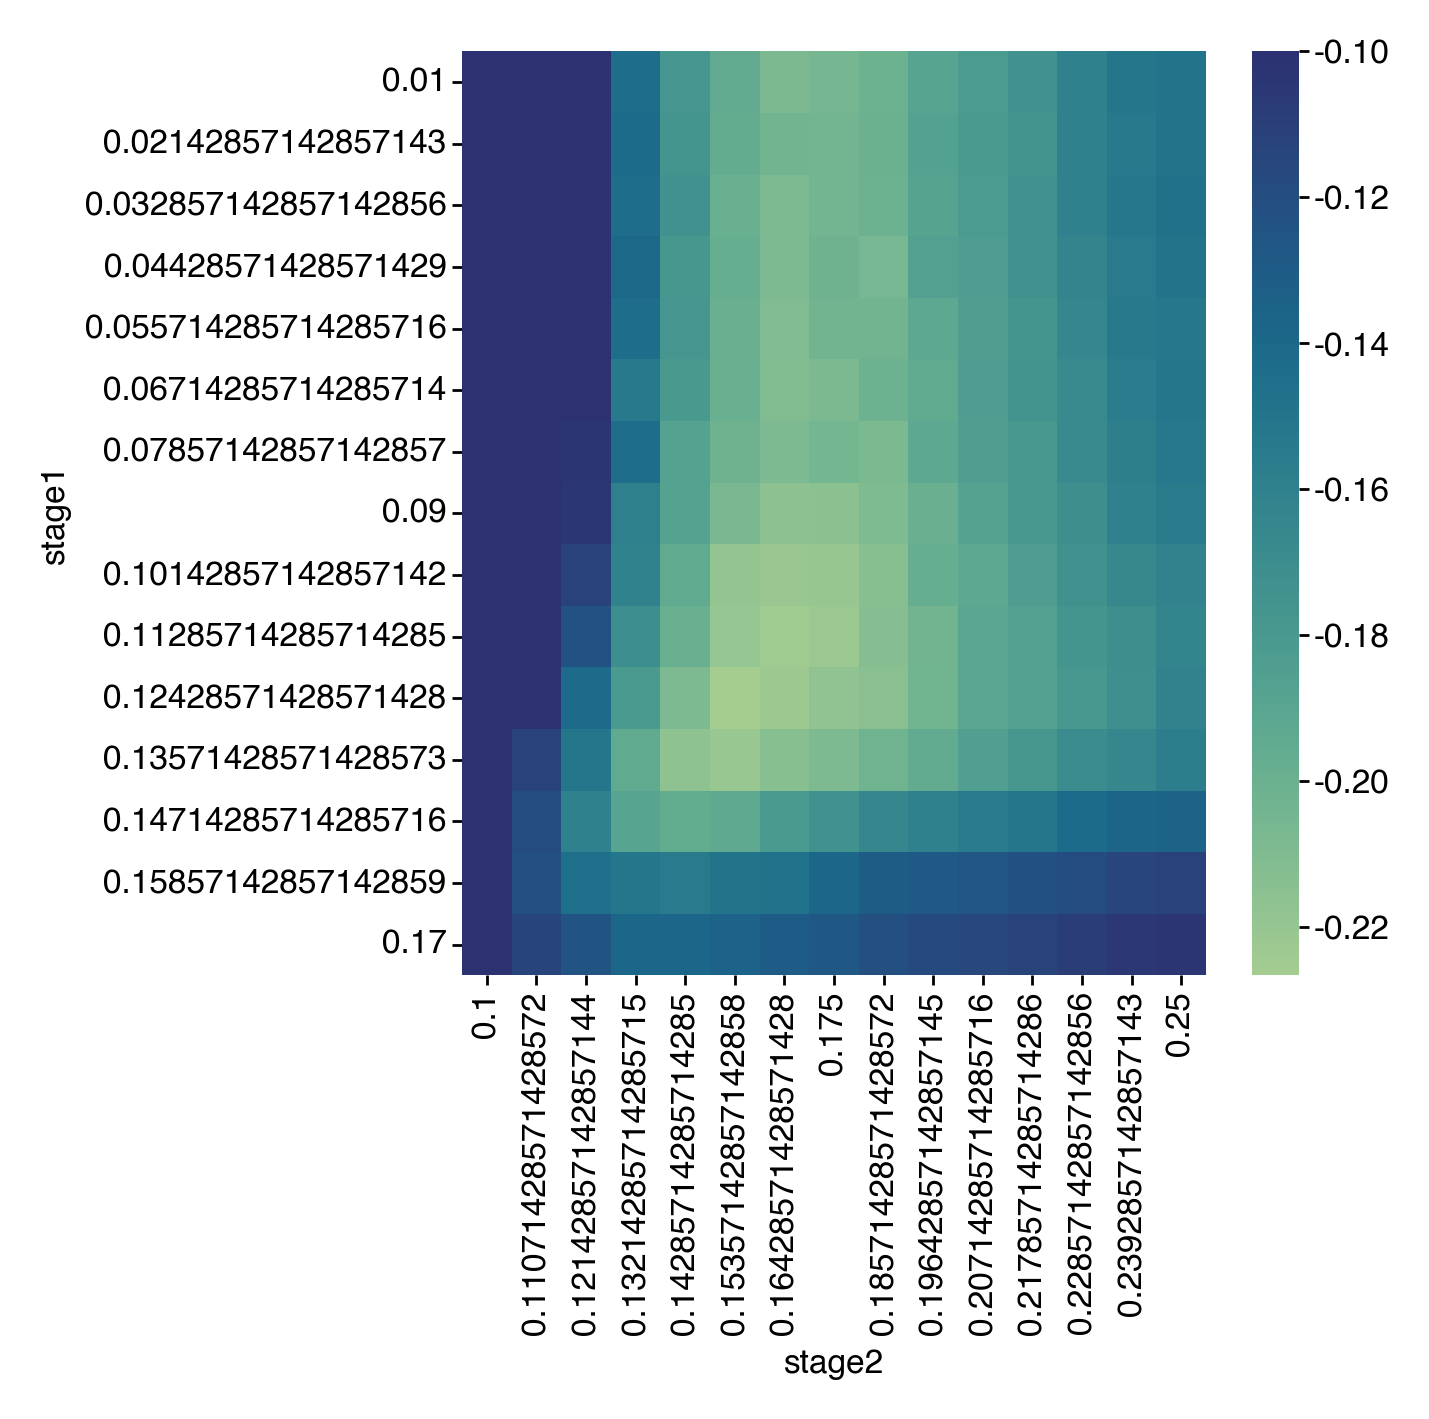

In [63]:
sns.heatmap(corrs.pivot_table(index='stage1', columns='stage2', values=0), cmap='crest', vmax=-0.1)

<Axes: xlabel='stage2', ylabel='stage1'>

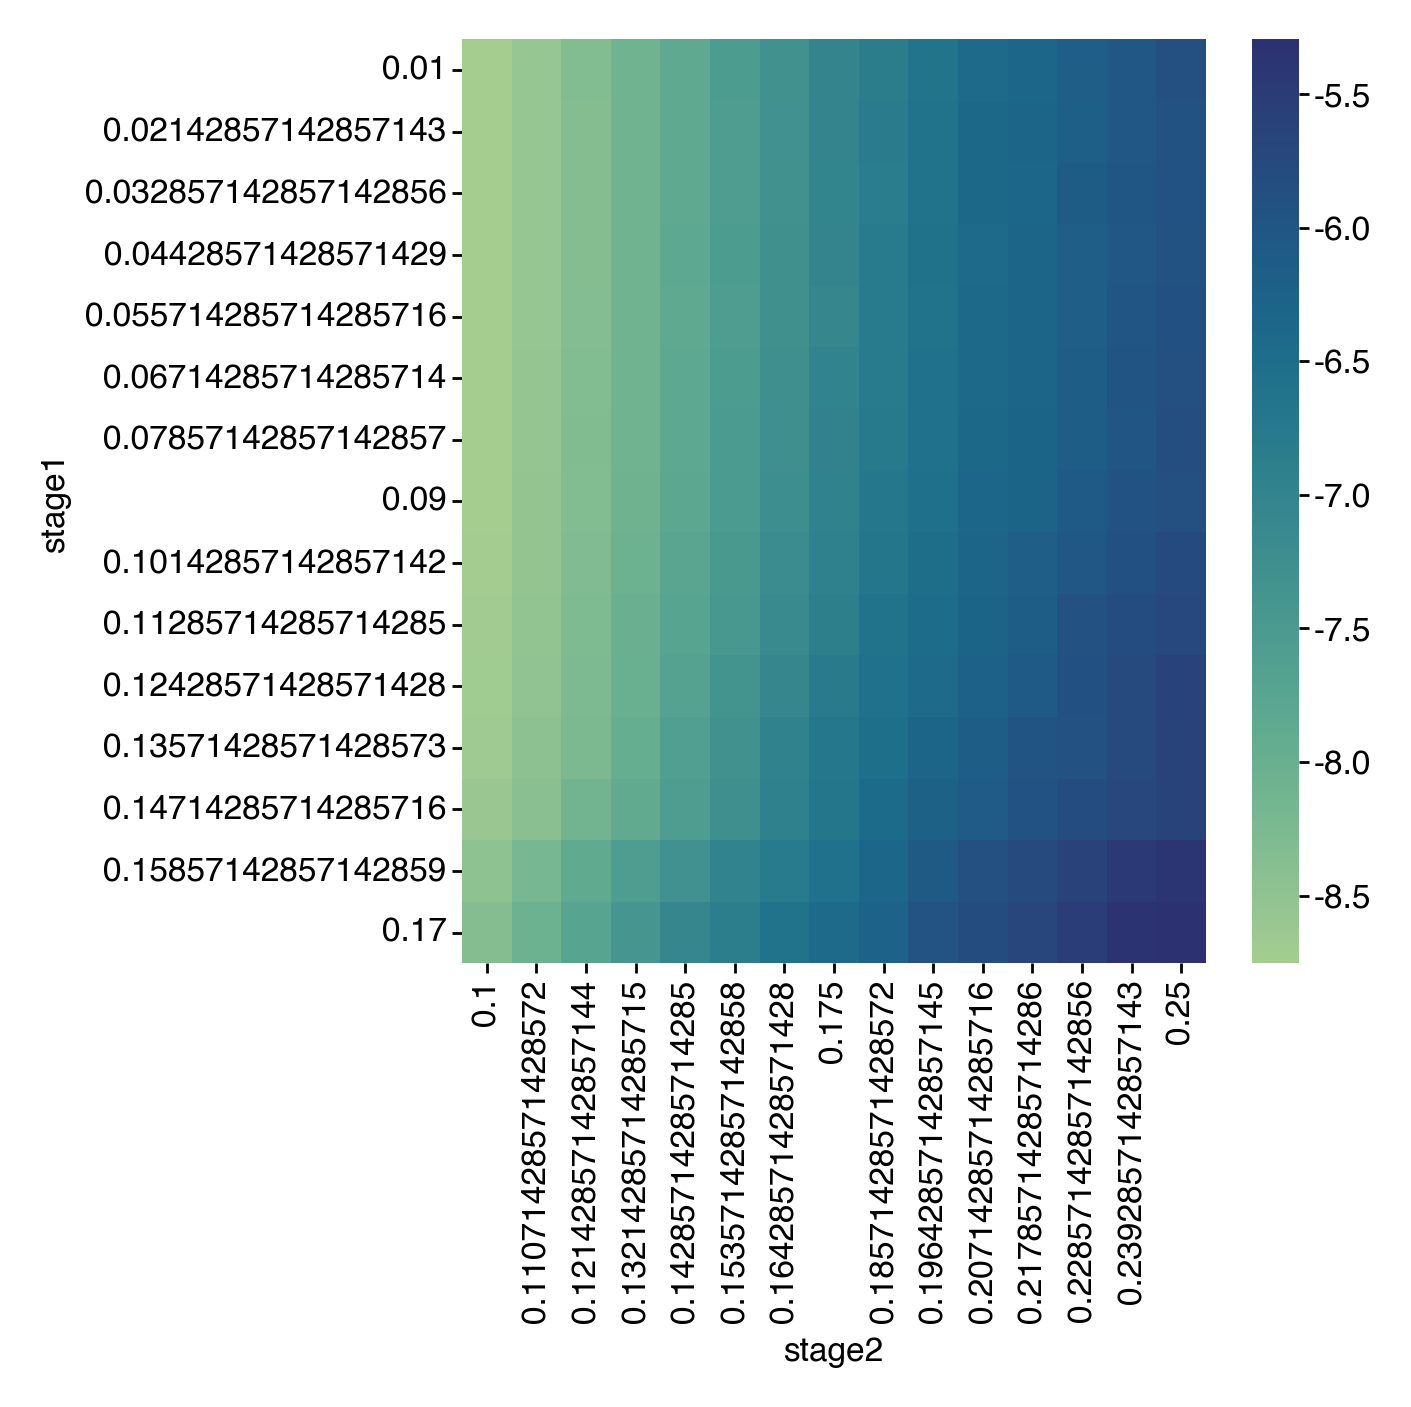

In [67]:
sns.heatmap(residuals.pivot_table(index='stage1', columns='stage2', values=0), cmap='crest')

In [68]:
stage1 = np.linspace(0.1, 0.14, 14)
stage2 = np.linspace(0.14, 0.18, 4 * 2 + 1)

In [69]:
m = 'log-xform-scale-sd'
h_copy = deepcopy(hypparams)
h_copy = merge(h_copy, model_params[m])

residuals = {}
corrs = {}

for _sd in tqdm(stage1):
    h_copy['age_sd'] = float(_sd)

    mdl1 = fit_model(features, h_copy, 2)

    long_hypparams = deepcopy(h_copy)
    long_hypparams["n_animals"] = len(long_mouse_ids)
    long_hypparams['n_opt_iter'] = 80
    long_hypparams['zero_mean'] = False

    fixed_params = mdl1['params']

    for _sd2 in tqdm(stage2):
        long_hypparams['age_sd'] = float(_sd2)

        long_mdl = constrained_fit(long_features, fixed_params, long_hypparams, 5, return_loss_on_error=False)

        _resid = long_mdl['true_ages'] - long_mdl['bio_ages']
        _resid = _resid[long_mdl['true_ages'] > 45]
    
        residuals[(_sd, _sd2)] = np.median(np.abs(_resid)) - 9.244
    
        tmp_df['beh_age'] = long_mdl['bio_ages']
        subset = make_death_df(tmp_df.reset_index(), 56, 71)
        
        c = subset[['death_rank', 'beh_age']].corr(method='spearman').iloc[0, 1]
        print(m, round(_sd, 3), round(_sd2, 3), round(c, 2))
        corrs[(_sd, _sd2)] = c

residuals = pd.Series(residuals)
corrs = pd.Series(corrs)
# fig, ax = plt.subplots(1, 2, figsize=(3, 1.5))
# corrs.plot(ax=ax[0])
# residuals.plot(ax=ax[1])

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.1 0.14 -0.18
log-xform-scale-sd 0.1 0.145 -0.2
log-xform-scale-sd 0.1 0.15 -0.21
log-xform-scale-sd 0.1 0.155 -0.21
log-xform-scale-sd 0.1 0.16 -0.21
log-xform-scale-sd 0.1 0.165 -0.22
log-xform-scale-sd 0.1 0.17 -0.22
log-xform-scale-sd 0.1 0.175 -0.22
log-xform-scale-sd 0.1 0.18 -0.22


  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.103 0.14 -0.18
log-xform-scale-sd 0.103 0.145 -0.2
log-xform-scale-sd 0.103 0.15 -0.21
log-xform-scale-sd 0.103 0.155 -0.21
log-xform-scale-sd 0.103 0.16 -0.22
log-xform-scale-sd 0.103 0.165 -0.22
log-xform-scale-sd 0.103 0.17 -0.22
log-xform-scale-sd 0.103 0.175 -0.22
log-xform-scale-sd 0.103 0.18 -0.21


  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.106 0.14 -0.19
log-xform-scale-sd 0.106 0.145 -0.2
log-xform-scale-sd 0.106 0.15 -0.22
log-xform-scale-sd 0.106 0.155 -0.22
log-xform-scale-sd 0.106 0.16 -0.22
log-xform-scale-sd 0.106 0.165 -0.22
log-xform-scale-sd 0.106 0.17 -0.22
log-xform-scale-sd 0.106 0.175 -0.22
log-xform-scale-sd 0.106 0.18 -0.22


  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.109 0.14 -0.19
log-xform-scale-sd 0.109 0.145 -0.2
log-xform-scale-sd 0.109 0.15 -0.22
log-xform-scale-sd 0.109 0.155 -0.22
log-xform-scale-sd 0.109 0.16 -0.22
log-xform-scale-sd 0.109 0.165 -0.22
log-xform-scale-sd 0.109 0.17 -0.22
log-xform-scale-sd 0.109 0.175 -0.22
log-xform-scale-sd 0.109 0.18 -0.22


  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.112 0.14 -0.2
log-xform-scale-sd 0.112 0.145 -0.2
log-xform-scale-sd 0.112 0.15 -0.21
log-xform-scale-sd 0.112 0.155 -0.22
log-xform-scale-sd 0.112 0.16 -0.22
log-xform-scale-sd 0.112 0.165 -0.23
log-xform-scale-sd 0.112 0.17 -0.22
log-xform-scale-sd 0.112 0.175 -0.22
log-xform-scale-sd 0.112 0.18 -0.22


  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.115 0.14 -0.2
log-xform-scale-sd 0.115 0.145 -0.2
log-xform-scale-sd 0.115 0.15 -0.22
log-xform-scale-sd 0.115 0.155 -0.22
log-xform-scale-sd 0.115 0.16 -0.22
log-xform-scale-sd 0.115 0.165 -0.22
log-xform-scale-sd 0.115 0.17 -0.23
log-xform-scale-sd 0.115 0.175 -0.22
log-xform-scale-sd 0.115 0.18 -0.22


  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.118 0.14 -0.2
log-xform-scale-sd 0.118 0.145 -0.21
log-xform-scale-sd 0.118 0.15 -0.21
log-xform-scale-sd 0.118 0.155 -0.23
log-xform-scale-sd 0.118 0.16 -0.23
log-xform-scale-sd 0.118 0.165 -0.23
log-xform-scale-sd 0.118 0.17 -0.22
log-xform-scale-sd 0.118 0.175 -0.22
log-xform-scale-sd 0.118 0.18 -0.22


  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.122 0.14 -0.2
log-xform-scale-sd 0.122 0.145 -0.21
log-xform-scale-sd 0.122 0.15 -0.22
log-xform-scale-sd 0.122 0.155 -0.22
log-xform-scale-sd 0.122 0.16 -0.22
log-xform-scale-sd 0.122 0.165 -0.22
log-xform-scale-sd 0.122 0.17 -0.22
log-xform-scale-sd 0.122 0.175 -0.22
log-xform-scale-sd 0.122 0.18 -0.22


  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.125 0.14 -0.21
log-xform-scale-sd 0.125 0.145 -0.21
log-xform-scale-sd 0.125 0.15 -0.22
log-xform-scale-sd 0.125 0.155 -0.23
log-xform-scale-sd 0.125 0.16 -0.23
log-xform-scale-sd 0.125 0.165 -0.22
log-xform-scale-sd 0.125 0.17 -0.22
log-xform-scale-sd 0.125 0.175 -0.22
log-xform-scale-sd 0.125 0.18 -0.21


  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.128 0.14 -0.21
log-xform-scale-sd 0.128 0.145 -0.22
log-xform-scale-sd 0.128 0.15 -0.22
log-xform-scale-sd 0.128 0.155 -0.22
log-xform-scale-sd 0.128 0.16 -0.22
log-xform-scale-sd 0.128 0.165 -0.22
log-xform-scale-sd 0.128 0.17 -0.21
log-xform-scale-sd 0.128 0.175 -0.22
log-xform-scale-sd 0.128 0.18 -0.22


  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.131 0.14 -0.21
log-xform-scale-sd 0.131 0.145 -0.22
log-xform-scale-sd 0.131 0.15 -0.22
log-xform-scale-sd 0.131 0.155 -0.23
log-xform-scale-sd 0.131 0.16 -0.22
log-xform-scale-sd 0.131 0.165 -0.22
log-xform-scale-sd 0.131 0.17 -0.22
log-xform-scale-sd 0.131 0.175 -0.21
log-xform-scale-sd 0.131 0.18 -0.21


  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.134 0.14 -0.21
log-xform-scale-sd 0.134 0.145 -0.22
log-xform-scale-sd 0.134 0.15 -0.22
log-xform-scale-sd 0.134 0.155 -0.22
log-xform-scale-sd 0.134 0.16 -0.22
log-xform-scale-sd 0.134 0.165 -0.21
log-xform-scale-sd 0.134 0.17 -0.22
log-xform-scale-sd 0.134 0.175 -0.21
log-xform-scale-sd 0.134 0.18 -0.21


  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.137 0.14 -0.21
log-xform-scale-sd 0.137 0.145 -0.21
log-xform-scale-sd 0.137 0.15 -0.22
log-xform-scale-sd 0.137 0.155 -0.22
log-xform-scale-sd 0.137 0.16 -0.21
log-xform-scale-sd 0.137 0.165 -0.21
log-xform-scale-sd 0.137 0.17 -0.21
log-xform-scale-sd 0.137 0.175 -0.21
log-xform-scale-sd 0.137 0.18 -0.2


  0%|          | 0/9 [00:00<?, ?it/s]

log-xform-scale-sd 0.14 0.14 -0.21
log-xform-scale-sd 0.14 0.145 -0.22
log-xform-scale-sd 0.14 0.15 -0.21
log-xform-scale-sd 0.14 0.155 -0.21
log-xform-scale-sd 0.14 0.16 -0.21
log-xform-scale-sd 0.14 0.165 -0.21
log-xform-scale-sd 0.14 0.17 -0.2
log-xform-scale-sd 0.14 0.175 -0.2
log-xform-scale-sd 0.14 0.18 -0.2


In [70]:
corrs.index.names = ['stage1', 'stage2']
residuals.index.names = ['stage1', 'stage2']

In [71]:
corrs = corrs.reset_index()
residuals = residuals.reset_index()

<Axes: xlabel='stage2', ylabel='stage1'>

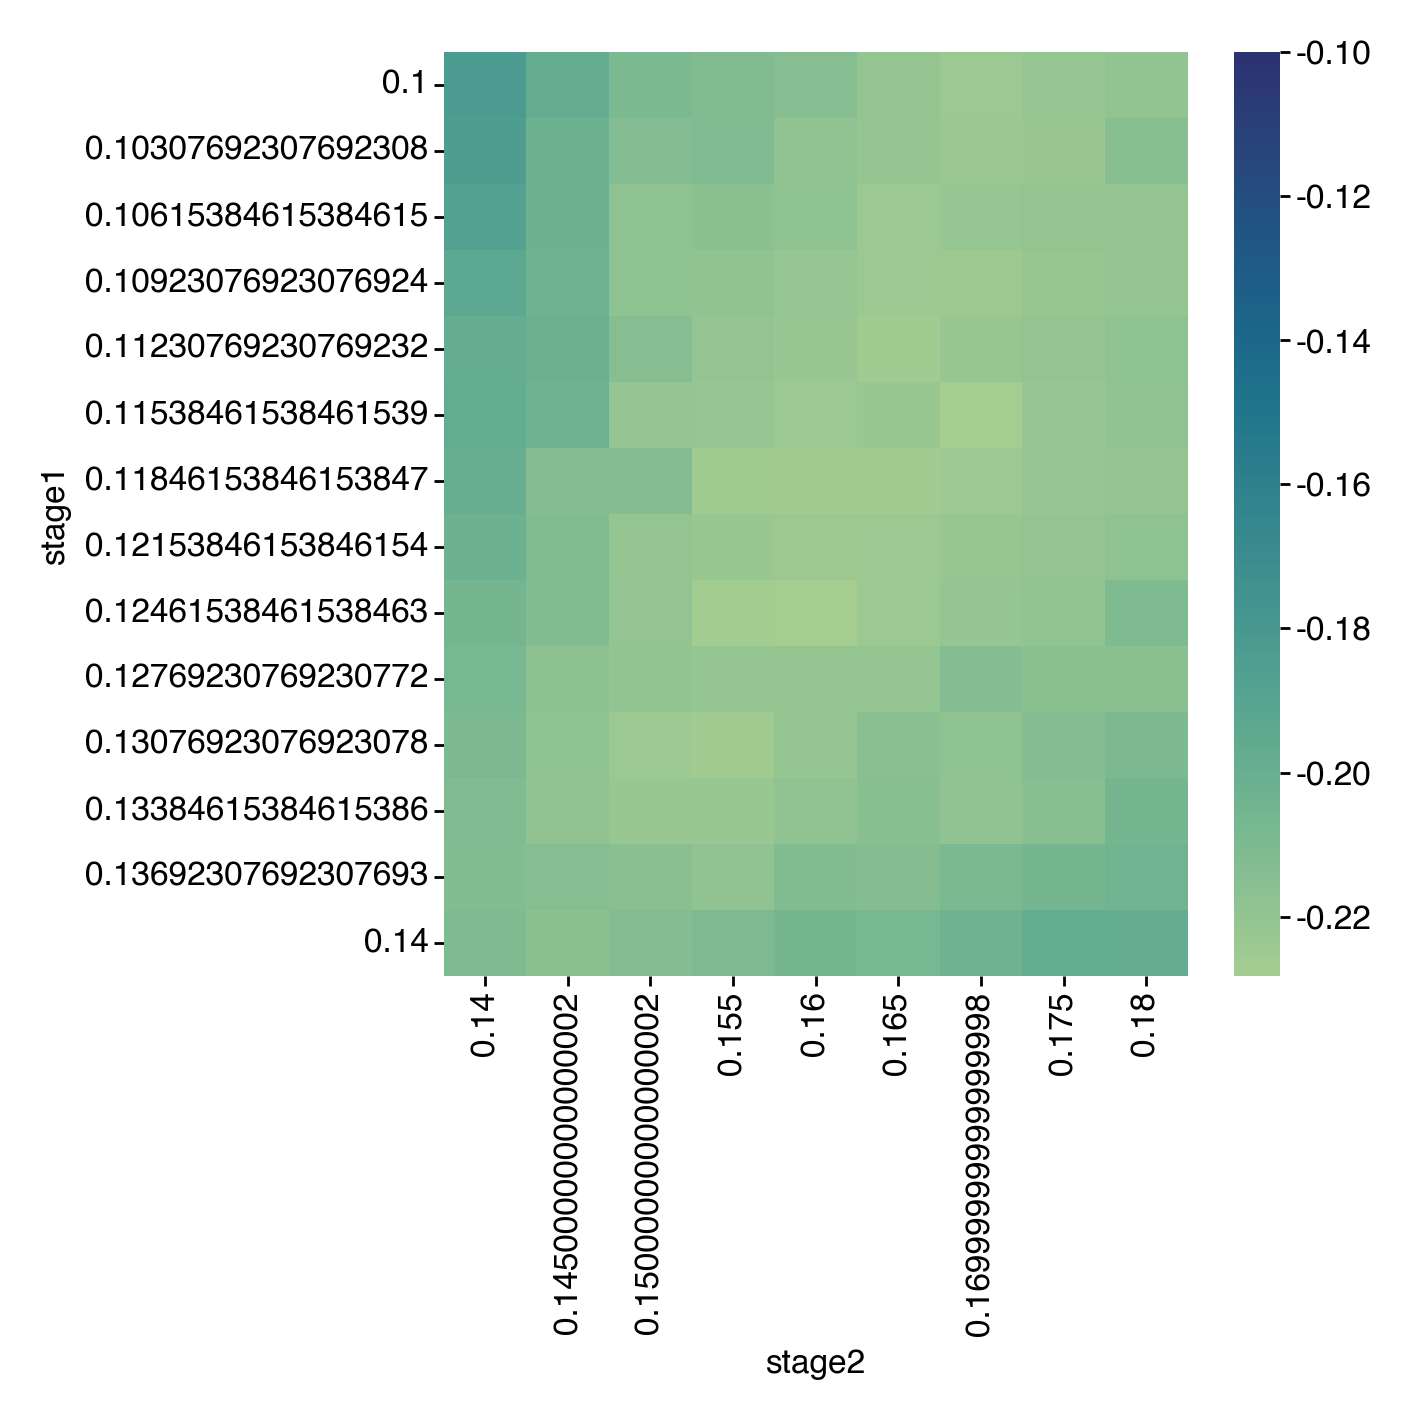

In [72]:
sns.heatmap(corrs.pivot_table(index='stage1', columns='stage2', values=0), cmap='crest', vmax=-0.1)

<Axes: xlabel='stage2', ylabel='stage1'>

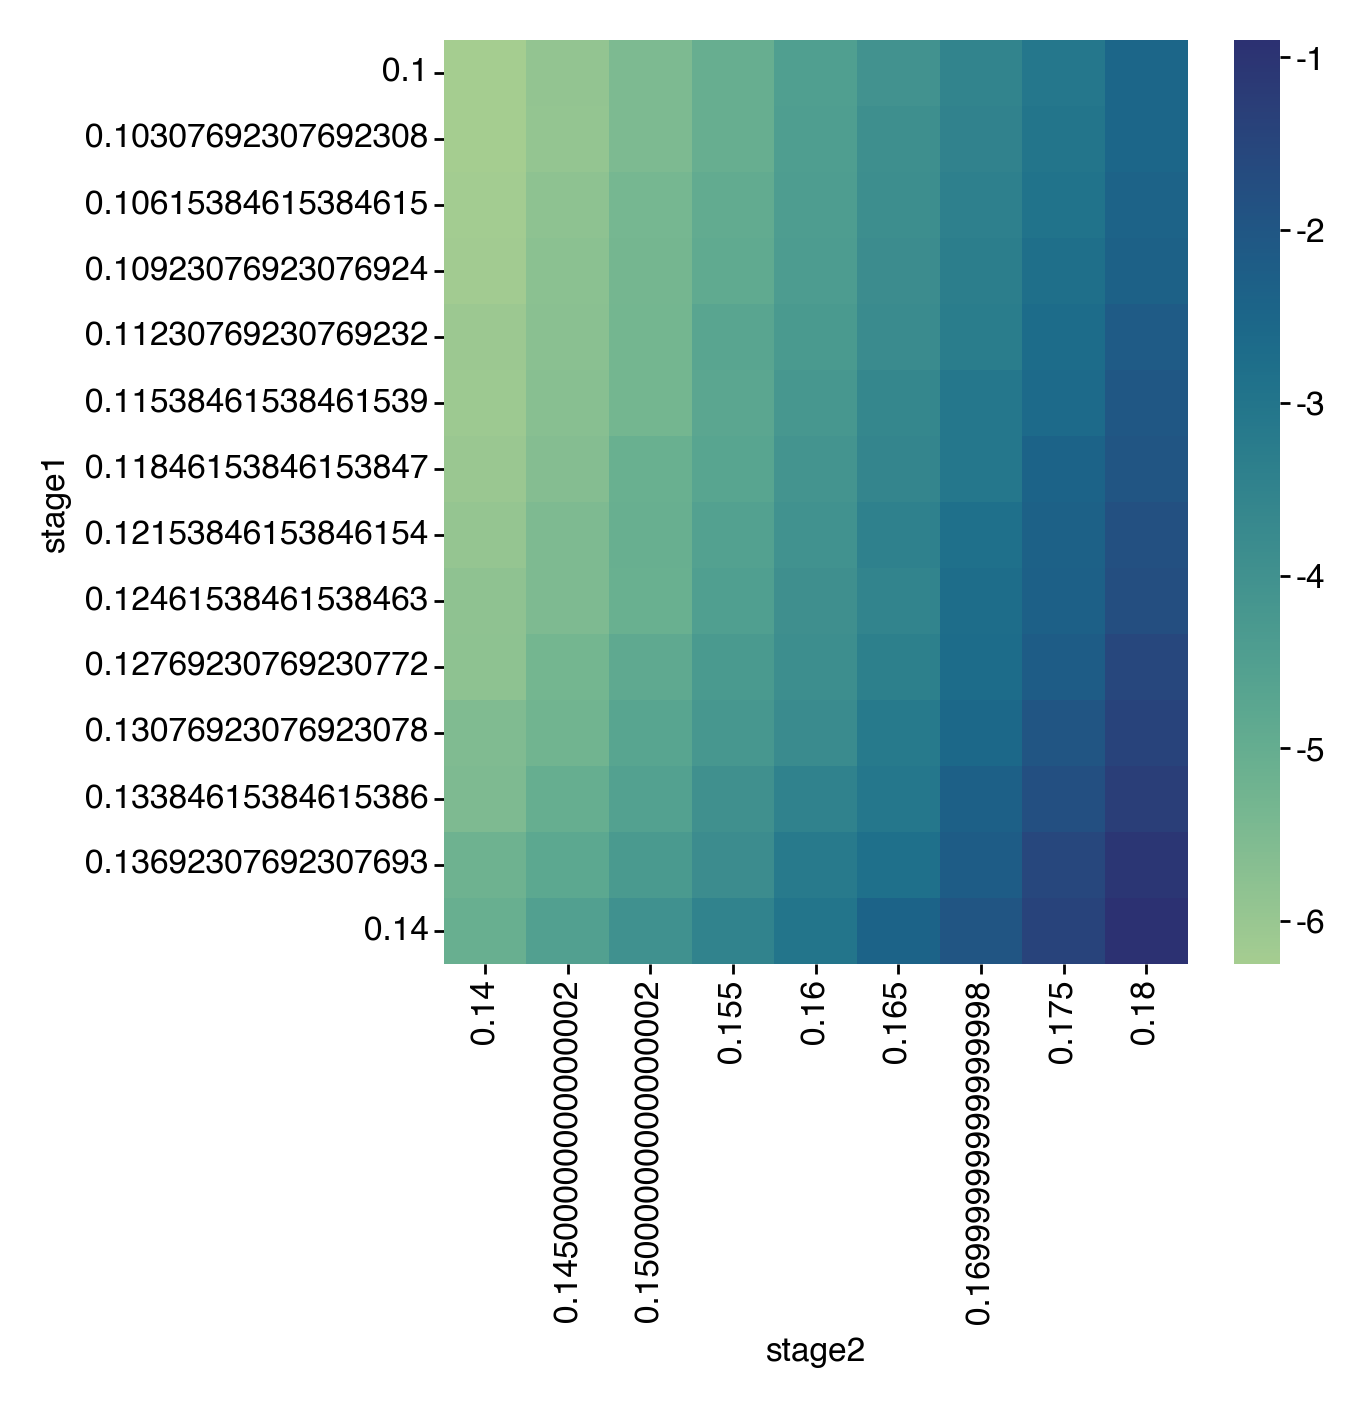

In [73]:
sns.heatmap(residuals.pivot_table(index='stage1', columns='stage2', values=0), cmap='crest')

## Adjust testing range to be smaller, try other parameters such as:

- number of splines
- number of development splines
- normalization via softmax
- 

In [74]:
hypparams

{'log_age': True,
 'min_age': 2,
 'max_age': 125,
 'age_sd': 0.16,
 'n_age_samples': 1000,
 'n_splines': 4,
 'n_syllables': 58,
 'n_development_splines': 4,
 'scale': 150,
 'normalize_by_softmax': True,
 'n_keep_sylls': 25,
 'n_sessions': 333,
 'lr': 0.25,
 'n_opt_iter': 150,
 'log_scale_sd': True}

In [76]:
grid = ParameterGrid({
    'n_splines': [4, 5],
    'n_development_splines': [4, 5],
    'normalize_by_softmax': [False, True]
})

In [77]:
for g in grid:
    print(g)
    break

{'n_development_splines': 4, 'n_splines': 4, 'normalize_by_softmax': False}


In [78]:
m = 'log-xform-scale-sd'
h_copy = deepcopy(hypparams)
h_copy = merge(h_copy, model_params[m])
h_copy['age_sd'] = 0.125

scan_df = []

for g in tqdm(list(grid)):
    h_copy = merge(h_copy, g)
    mdl1 = fit_model(features, h_copy, 2)

    long_hypparams = deepcopy(h_copy)
    long_hypparams["n_animals"] = len(long_mouse_ids)
    long_hypparams['n_opt_iter'] = 80
    long_hypparams['zero_mean'] = False
    long_hypparams['age_sd'] = 0.16

    fixed_params = mdl1['params']

    # for _sd2 in tqdm(stage2):

    long_mdl = constrained_fit(long_features, fixed_params, long_hypparams, 5, return_loss_on_error=False)

    _resid = long_mdl['true_ages'] - long_mdl['bio_ages']
    _resid = _resid[long_mdl['true_ages'] > 45]

    g['resid'] = np.median(np.abs(_resid)) - 9.244

    tmp_df['beh_age'] = long_mdl['bio_ages']
    subset = make_death_df(tmp_df.reset_index(), 56, 71)
    
    c = subset[['death_rank', 'beh_age']].corr(method='spearman').iloc[0, 1]
    print(m, round(_sd, 3), round(_sd2, 3), round(c, 2))
    
    g['corr'] = c
    scan_df.append(g)

scan_df = pd.DataFrame(scan_df)

  0%|          | 0/8 [00:00<?, ?it/s]

log-xform-scale-sd 0.14 0.18 -0.1
log-xform-scale-sd 0.14 0.18 -0.23
log-xform-scale-sd 0.14 0.18 -0.14
log-xform-scale-sd 0.14 0.18 -0.2
log-xform-scale-sd 0.14 0.18 -0.1
log-xform-scale-sd 0.14 0.18 -0.18
log-xform-scale-sd 0.14 0.18 -0.13
log-xform-scale-sd 0.14 0.18 -0.19


In [79]:
scan_df.sort_values(by='corr')

,n_development_splines,n_splines,normalize_by_softmax,resid,corr
1,4,4,True,-3.937607,-0.226917
3,4,5,True,-4.569201,-0.196275
7,5,5,True,-4.431094,-0.186704
5,5,4,True,-3.547112,-0.182242
2,4,5,False,5.421569,-0.137814
6,5,5,False,4.947177,-0.126558
0,4,4,False,1.397079,-0.103114
4,5,4,False,1.119977,-0.101155


In [87]:
stage1 = np.linspace(0.05, 0.14, 15)
stage2 = np.linspace(0.1, 0.2, 15)

In [88]:
m = 'log-xform-scale-sd'
h_copy = deepcopy(hypparams)
h_copy = merge(h_copy, model_params[m])
h_copy['normalize_by_softmax'] = False

residuals = {}
corrs = {}

for _sd in tqdm(stage1):
    h_copy['age_sd'] = float(_sd)

    mdl1 = fit_model(features, h_copy, 2)

    long_hypparams = deepcopy(h_copy)
    long_hypparams["n_animals"] = len(long_mouse_ids)
    long_hypparams['n_opt_iter'] = 80
    long_hypparams['zero_mean'] = False

    fixed_params = mdl1['params']

    for _sd2 in tqdm(stage2):
        long_hypparams['age_sd'] = float(_sd2)

        long_mdl = constrained_fit(long_features, fixed_params, long_hypparams, 5, return_loss_on_error=False)

        _resid = long_mdl['true_ages'] - long_mdl['bio_ages']
        _resid = _resid[long_mdl['true_ages'] > 45]
    
        residuals[(_sd, _sd2)] = np.median(np.abs(_resid)) - 9.244
    
        tmp_df['beh_age'] = long_mdl['bio_ages']
        subset = make_death_df(tmp_df.reset_index(), 56, 71)
        
        c = subset[['death_rank', 'beh_age']].corr(method='spearman').iloc[0, 1]
        print(m, round(_sd, 3), round(_sd2, 3), round(c, 2))
        corrs[(_sd, _sd2)] = c

residuals = pd.Series(residuals)
corrs = pd.Series(corrs)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.05 0.1 -0.05
log-xform-scale-sd 0.05 0.107 -0.07
log-xform-scale-sd 0.05 0.114 -0.08
log-xform-scale-sd 0.05 0.121 -0.1
log-xform-scale-sd 0.05 0.129 -0.12
log-xform-scale-sd 0.05 0.136 -0.14
log-xform-scale-sd 0.05 0.143 -0.13
log-xform-scale-sd 0.05 0.15 -0.14
log-xform-scale-sd 0.05 0.157 -0.14
log-xform-scale-sd 0.05 0.164 -0.14
log-xform-scale-sd 0.05 0.171 -0.12
log-xform-scale-sd 0.05 0.179 -0.12
log-xform-scale-sd 0.05 0.186 -0.11
log-xform-scale-sd 0.05 0.193 -0.1
log-xform-scale-sd 0.05 0.2 -0.09


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.056 0.1 -0.05
log-xform-scale-sd 0.056 0.107 -0.07
log-xform-scale-sd 0.056 0.114 -0.08
log-xform-scale-sd 0.056 0.121 -0.11
log-xform-scale-sd 0.056 0.129 -0.12
log-xform-scale-sd 0.056 0.136 -0.13
log-xform-scale-sd 0.056 0.143 -0.14
log-xform-scale-sd 0.056 0.15 -0.14
log-xform-scale-sd 0.056 0.157 -0.14
log-xform-scale-sd 0.056 0.164 -0.14
log-xform-scale-sd 0.056 0.171 -0.13
log-xform-scale-sd 0.056 0.179 -0.12
log-xform-scale-sd 0.056 0.186 -0.11
log-xform-scale-sd 0.056 0.193 -0.1
log-xform-scale-sd 0.056 0.2 -0.09


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.063 0.1 -0.05
log-xform-scale-sd 0.063 0.107 -0.07
log-xform-scale-sd 0.063 0.114 -0.09
log-xform-scale-sd 0.063 0.121 -0.11
log-xform-scale-sd 0.063 0.129 -0.12
log-xform-scale-sd 0.063 0.136 -0.14
log-xform-scale-sd 0.063 0.143 -0.14
log-xform-scale-sd 0.063 0.15 -0.14
log-xform-scale-sd 0.063 0.157 -0.15
log-xform-scale-sd 0.063 0.164 -0.15
log-xform-scale-sd 0.063 0.171 -0.13
log-xform-scale-sd 0.063 0.179 -0.12
log-xform-scale-sd 0.063 0.186 -0.11
log-xform-scale-sd 0.063 0.193 -0.1
log-xform-scale-sd 0.063 0.2 -0.1


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.069 0.1 -0.06
log-xform-scale-sd 0.069 0.107 -0.07
log-xform-scale-sd 0.069 0.114 -0.09
log-xform-scale-sd 0.069 0.121 -0.11
log-xform-scale-sd 0.069 0.129 -0.13
log-xform-scale-sd 0.069 0.136 -0.15
log-xform-scale-sd 0.069 0.143 -0.14
log-xform-scale-sd 0.069 0.15 -0.15
log-xform-scale-sd 0.069 0.157 -0.15
log-xform-scale-sd 0.069 0.164 -0.14
log-xform-scale-sd 0.069 0.171 -0.13
log-xform-scale-sd 0.069 0.179 -0.12
log-xform-scale-sd 0.069 0.186 -0.11
log-xform-scale-sd 0.069 0.193 -0.11
log-xform-scale-sd 0.069 0.2 -0.1


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.076 0.1 -0.06
log-xform-scale-sd 0.076 0.107 -0.08
log-xform-scale-sd 0.076 0.114 -0.09
log-xform-scale-sd 0.076 0.121 -0.11
log-xform-scale-sd 0.076 0.129 -0.13
log-xform-scale-sd 0.076 0.136 -0.14
log-xform-scale-sd 0.076 0.143 -0.14
log-xform-scale-sd 0.076 0.15 -0.15
log-xform-scale-sd 0.076 0.157 -0.15
log-xform-scale-sd 0.076 0.164 -0.14
log-xform-scale-sd 0.076 0.171 -0.14
log-xform-scale-sd 0.076 0.179 -0.12
log-xform-scale-sd 0.076 0.186 -0.12
log-xform-scale-sd 0.076 0.193 -0.11
log-xform-scale-sd 0.076 0.2 -0.1


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.082 0.1 -0.06
log-xform-scale-sd 0.082 0.107 -0.08
log-xform-scale-sd 0.082 0.114 -0.09
log-xform-scale-sd 0.082 0.121 -0.12
log-xform-scale-sd 0.082 0.129 -0.14
log-xform-scale-sd 0.082 0.136 -0.15
log-xform-scale-sd 0.082 0.143 -0.15
log-xform-scale-sd 0.082 0.15 -0.16
log-xform-scale-sd 0.082 0.157 -0.16
log-xform-scale-sd 0.082 0.164 -0.15
log-xform-scale-sd 0.082 0.171 -0.14
log-xform-scale-sd 0.082 0.179 -0.13
log-xform-scale-sd 0.082 0.186 -0.12
log-xform-scale-sd 0.082 0.193 -0.11
log-xform-scale-sd 0.082 0.2 -0.1


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.089 0.1 -0.07
log-xform-scale-sd 0.089 0.107 -0.08
log-xform-scale-sd 0.089 0.114 -0.1
log-xform-scale-sd 0.089 0.121 -0.12
log-xform-scale-sd 0.089 0.129 -0.14
log-xform-scale-sd 0.089 0.136 -0.15
log-xform-scale-sd 0.089 0.143 -0.16
log-xform-scale-sd 0.089 0.15 -0.16
log-xform-scale-sd 0.089 0.157 -0.16
log-xform-scale-sd 0.089 0.164 -0.15
log-xform-scale-sd 0.089 0.171 -0.14
log-xform-scale-sd 0.089 0.179 -0.13
log-xform-scale-sd 0.089 0.186 -0.12
log-xform-scale-sd 0.089 0.193 -0.12
log-xform-scale-sd 0.089 0.2 -0.11


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.095 0.1 -0.06
log-xform-scale-sd 0.095 0.107 -0.09
log-xform-scale-sd 0.095 0.114 -0.11
log-xform-scale-sd 0.095 0.121 -0.13
log-xform-scale-sd 0.095 0.129 -0.15
log-xform-scale-sd 0.095 0.136 -0.16
log-xform-scale-sd 0.095 0.143 -0.16
log-xform-scale-sd 0.095 0.15 -0.16
log-xform-scale-sd 0.095 0.157 -0.15
log-xform-scale-sd 0.095 0.164 -0.15
log-xform-scale-sd 0.095 0.171 -0.14
log-xform-scale-sd 0.095 0.179 -0.13
log-xform-scale-sd 0.095 0.186 -0.12
log-xform-scale-sd 0.095 0.193 -0.12
log-xform-scale-sd 0.095 0.2 -0.11


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.101 0.1 -0.07
log-xform-scale-sd 0.101 0.107 -0.09
log-xform-scale-sd 0.101 0.114 -0.11
log-xform-scale-sd 0.101 0.121 -0.14
log-xform-scale-sd 0.101 0.129 -0.15
log-xform-scale-sd 0.101 0.136 -0.17
log-xform-scale-sd 0.101 0.143 -0.17
log-xform-scale-sd 0.101 0.15 -0.16
log-xform-scale-sd 0.101 0.157 -0.16
log-xform-scale-sd 0.101 0.164 -0.15
log-xform-scale-sd 0.101 0.171 -0.15
log-xform-scale-sd 0.101 0.179 -0.13
log-xform-scale-sd 0.101 0.186 -0.12
log-xform-scale-sd 0.101 0.193 -0.12
log-xform-scale-sd 0.101 0.2 -0.11


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.108 0.1 -0.08
log-xform-scale-sd 0.108 0.107 -0.1
log-xform-scale-sd 0.108 0.114 -0.12
log-xform-scale-sd 0.108 0.121 -0.15
log-xform-scale-sd 0.108 0.129 -0.16
log-xform-scale-sd 0.108 0.136 -0.17
log-xform-scale-sd 0.108 0.143 -0.17
log-xform-scale-sd 0.108 0.15 -0.16
log-xform-scale-sd 0.108 0.157 -0.15
log-xform-scale-sd 0.108 0.164 -0.15
log-xform-scale-sd 0.108 0.171 -0.14
log-xform-scale-sd 0.108 0.179 -0.13
log-xform-scale-sd 0.108 0.186 -0.13
log-xform-scale-sd 0.108 0.193 -0.12
log-xform-scale-sd 0.108 0.2 -0.11


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.114 0.1 -0.09
log-xform-scale-sd 0.114 0.107 -0.11
log-xform-scale-sd 0.114 0.114 -0.13
log-xform-scale-sd 0.114 0.121 -0.15
log-xform-scale-sd 0.114 0.129 -0.16
log-xform-scale-sd 0.114 0.136 -0.17
log-xform-scale-sd 0.114 0.143 -0.17
log-xform-scale-sd 0.114 0.15 -0.16
log-xform-scale-sd 0.114 0.157 -0.15
log-xform-scale-sd 0.114 0.164 -0.14
log-xform-scale-sd 0.114 0.171 -0.13
log-xform-scale-sd 0.114 0.179 -0.13
log-xform-scale-sd 0.114 0.186 -0.12
log-xform-scale-sd 0.114 0.193 -0.12
log-xform-scale-sd 0.114 0.2 -0.11


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.121 0.1 -0.1
log-xform-scale-sd 0.121 0.107 -0.12
log-xform-scale-sd 0.121 0.114 -0.14
log-xform-scale-sd 0.121 0.121 -0.14
log-xform-scale-sd 0.121 0.129 -0.15
log-xform-scale-sd 0.121 0.136 -0.14
log-xform-scale-sd 0.121 0.143 -0.15
log-xform-scale-sd 0.121 0.15 -0.14
log-xform-scale-sd 0.121 0.157 -0.14
log-xform-scale-sd 0.121 0.164 -0.13
log-xform-scale-sd 0.121 0.171 -0.12
log-xform-scale-sd 0.121 0.179 -0.12
log-xform-scale-sd 0.121 0.186 -0.11
log-xform-scale-sd 0.121 0.193 -0.11
log-xform-scale-sd 0.121 0.2 -0.11


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.127 0.1 -0.08
log-xform-scale-sd 0.127 0.107 -0.1
log-xform-scale-sd 0.127 0.114 -0.1
log-xform-scale-sd 0.127 0.121 -0.1
log-xform-scale-sd 0.127 0.129 -0.09
log-xform-scale-sd 0.127 0.136 -0.09
log-xform-scale-sd 0.127 0.143 -0.08
log-xform-scale-sd 0.127 0.15 -0.08
log-xform-scale-sd 0.127 0.157 -0.08
log-xform-scale-sd 0.127 0.164 -0.08
log-xform-scale-sd 0.127 0.171 -0.08
log-xform-scale-sd 0.127 0.179 -0.07
log-xform-scale-sd 0.127 0.186 -0.07
log-xform-scale-sd 0.127 0.193 -0.07
log-xform-scale-sd 0.127 0.2 -0.07


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.134 0.1 -0.05
log-xform-scale-sd 0.134 0.107 -0.06
log-xform-scale-sd 0.134 0.114 -0.06
log-xform-scale-sd 0.134 0.121 -0.06
log-xform-scale-sd 0.134 0.129 -0.06
log-xform-scale-sd 0.134 0.136 -0.05
log-xform-scale-sd 0.134 0.143 -0.05
log-xform-scale-sd 0.134 0.15 -0.04
log-xform-scale-sd 0.134 0.157 -0.04
log-xform-scale-sd 0.134 0.164 -0.03
log-xform-scale-sd 0.134 0.171 -0.03
log-xform-scale-sd 0.134 0.179 -0.03
log-xform-scale-sd 0.134 0.186 -0.03
log-xform-scale-sd 0.134 0.193 -0.03
log-xform-scale-sd 0.134 0.2 -0.02


  0%|          | 0/15 [00:00<?, ?it/s]

log-xform-scale-sd 0.14 0.1 -0.05
log-xform-scale-sd 0.14 0.107 -0.06
log-xform-scale-sd 0.14 0.114 -0.05
log-xform-scale-sd 0.14 0.121 -0.05
log-xform-scale-sd 0.14 0.129 -0.05
log-xform-scale-sd 0.14 0.136 -0.05
log-xform-scale-sd 0.14 0.143 -0.04
log-xform-scale-sd 0.14 0.15 -0.03
log-xform-scale-sd 0.14 0.157 -0.03
log-xform-scale-sd 0.14 0.164 -0.03
log-xform-scale-sd 0.14 0.171 -0.02
log-xform-scale-sd 0.14 0.179 -0.02
log-xform-scale-sd 0.14 0.186 -0.02
log-xform-scale-sd 0.14 0.193 -0.01
log-xform-scale-sd 0.14 0.2 -0.01


In [89]:
corrs.index.names = ['stage1', 'stage2']
residuals.index.names = ['stage1', 'stage2']

In [90]:
corrs = corrs.reset_index()
residuals = residuals.reset_index()

<Axes: xlabel='stage2', ylabel='stage1'>

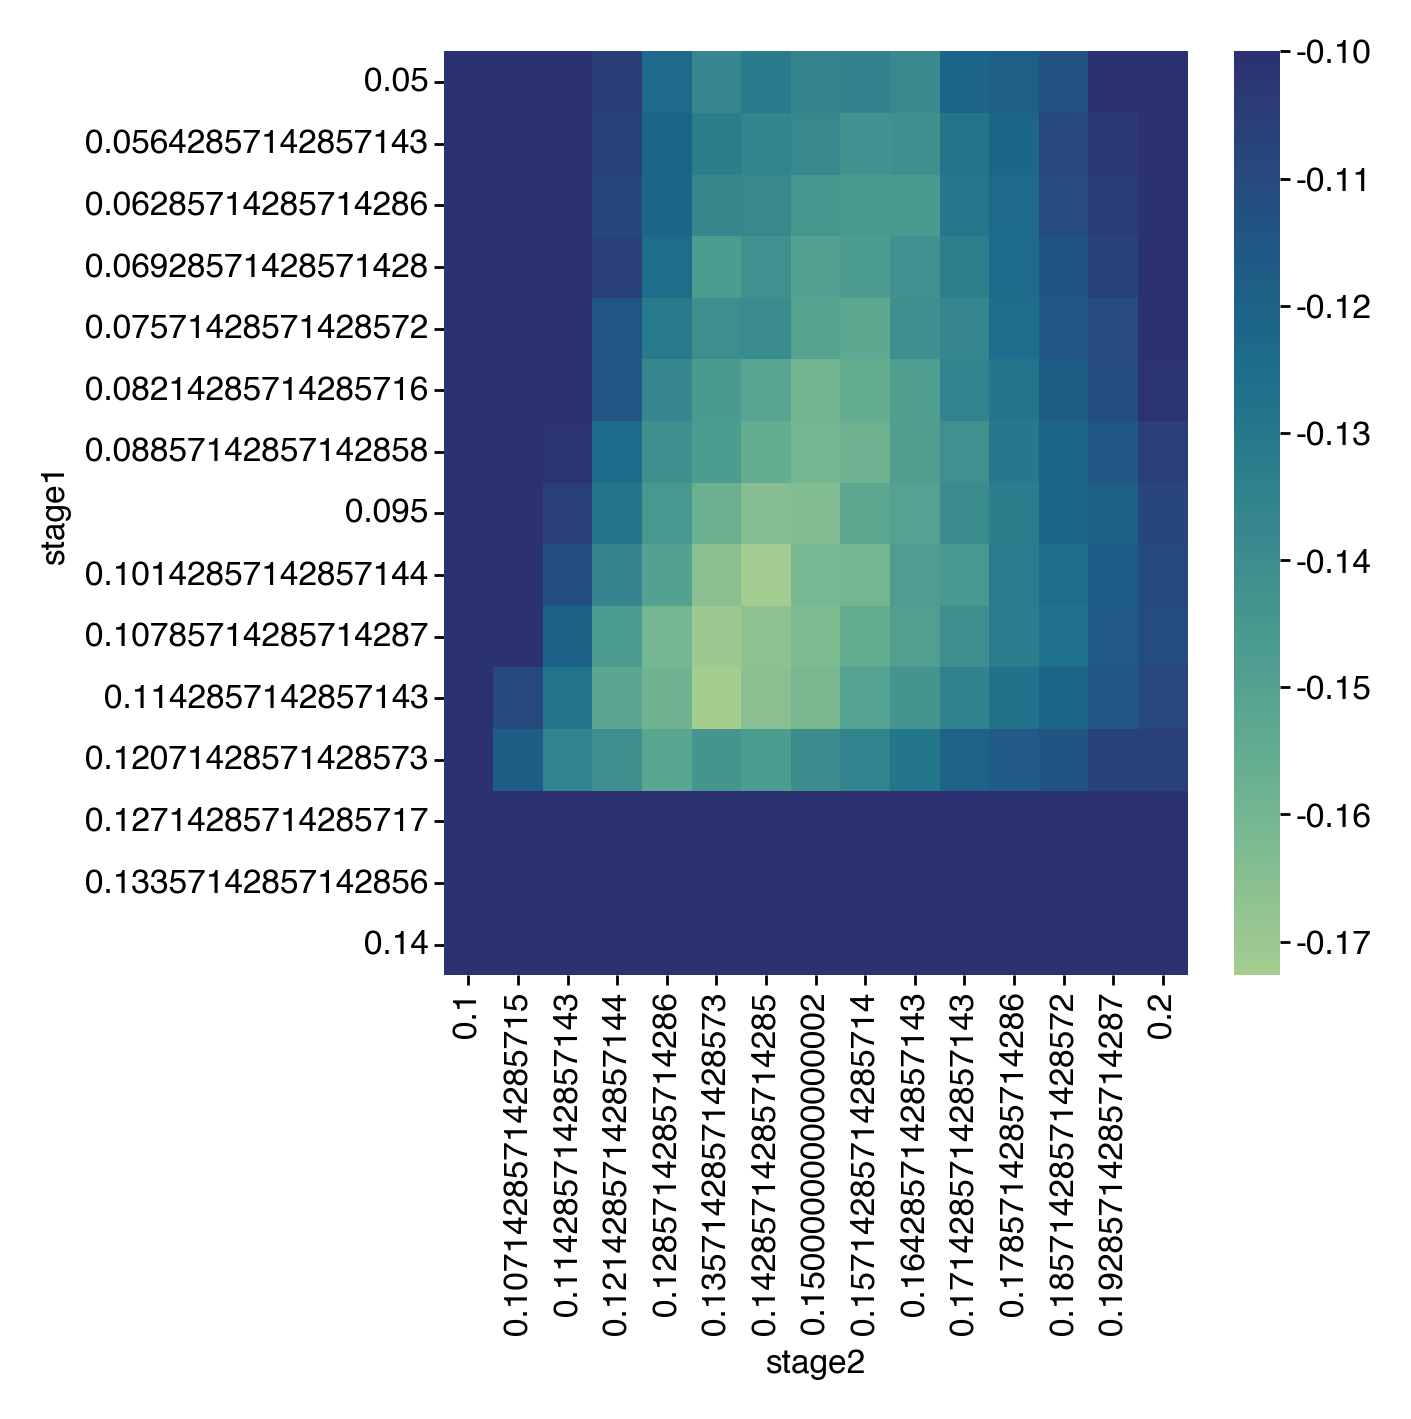

In [91]:
sns.heatmap(corrs.pivot_table(index='stage1', columns='stage2', values=0), cmap='crest', vmax=-0.1)

<Axes: xlabel='stage2', ylabel='stage1'>

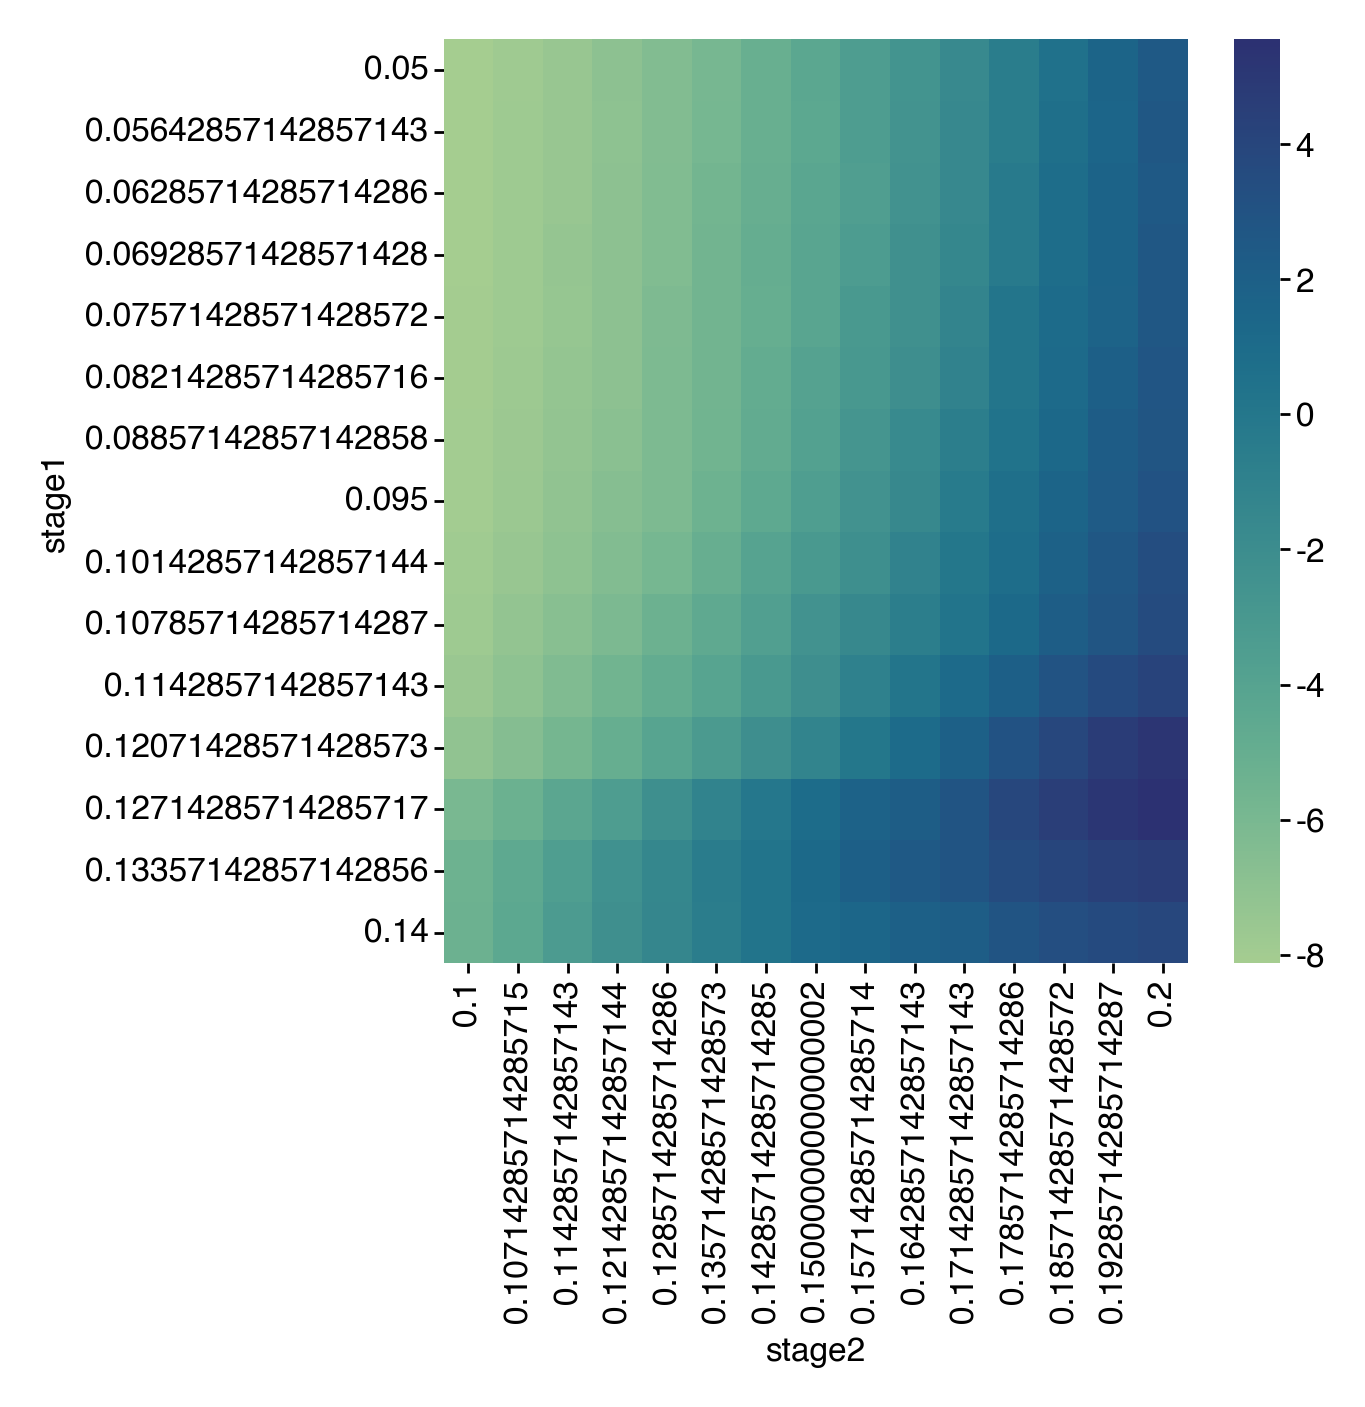

In [92]:
sns.heatmap(residuals.pivot_table(index='stage1', columns='stage2', values=0), cmap='crest')

## Try optimal fit

In [93]:
m = 'log-xform-scale-sd'
h_copy = deepcopy(hypparams)
h_copy = merge(h_copy, model_params[m])
h_copy['age_sd'] = 0.125

scan_df = []

mdl1 = fit_model(features, h_copy, 2)

long_hypparams = deepcopy(h_copy)
long_hypparams["n_animals"] = len(long_mouse_ids)
long_hypparams['n_opt_iter'] = 80
long_hypparams['zero_mean'] = False
long_hypparams['age_sd'] = 0.16

fixed_params = mdl1['params']

long_mdl = constrained_fit(long_features, fixed_params, long_hypparams, 5, return_loss_on_error=False)

_resid = long_mdl['true_ages'] - long_mdl['bio_ages']
_resid = _resid[long_mdl['true_ages'] > 45]

tmp_df['beh_age'] = long_mdl['bio_ages']
subset = make_death_df(tmp_df.reset_index(), 56, 71)

c = subset[['death_rank', 'beh_age']].corr(method='spearman').iloc[0, 1]


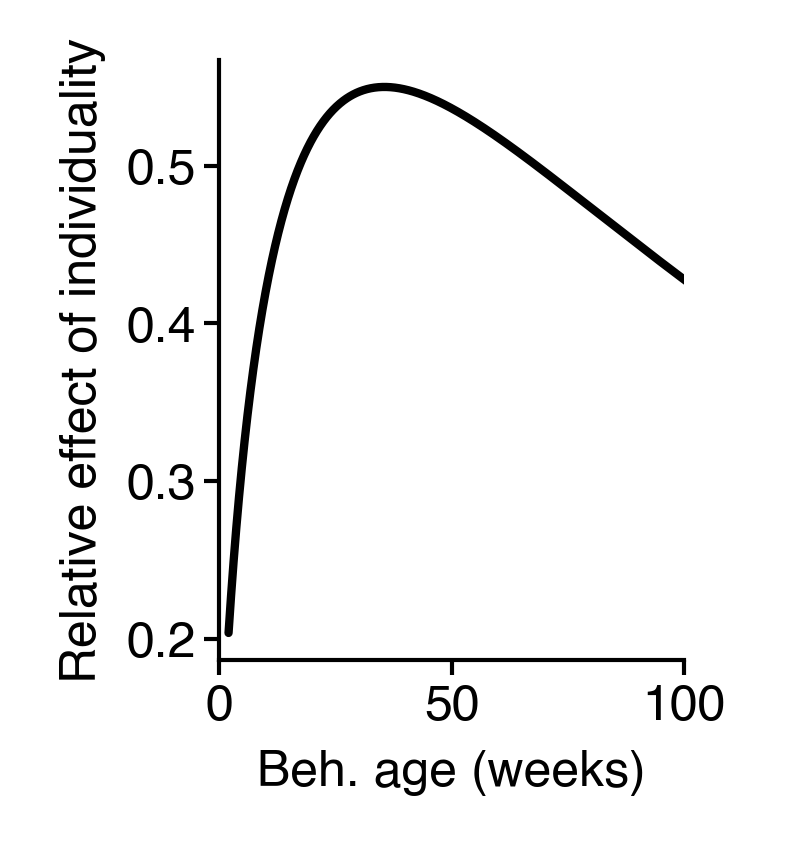

In [94]:
comps = long_mdl['init_components']

x = long_mdl['params']['development_weights']
dev = np.exp(x @ comps.bases['development']).squeeze()

fig = figure(1, 1.3)
ax = fig.gca()
ax.plot(comps.age_unnormalizer(comps.age_samples), dev, color='k')
plt.xlim(0, 100)
# plt.ylim(0, None)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of individuality")
sns.despine()

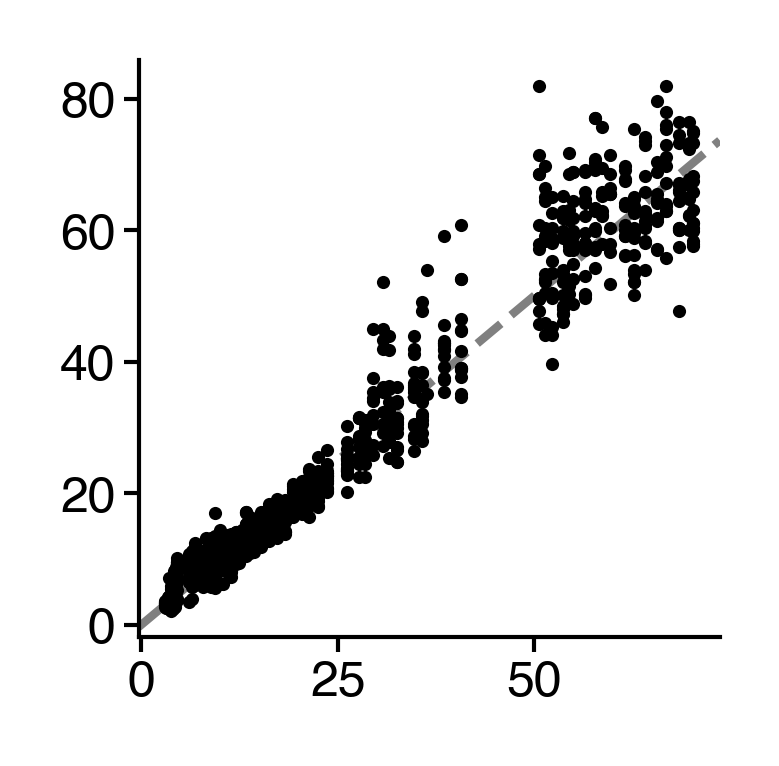

In [96]:
fig = figure(1.25, 1.25)
plt.scatter(long_mdl['true_ages'], long_mdl['bio_ages'], c='k', s=2.5, lw=0)
a = add_identity(plt.gca(), c='gray', ls='--', zorder=-1)
sns.despine()

Observed fit
4 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 -0.08


/tmp/ipykernel_44171/679344276.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.45))


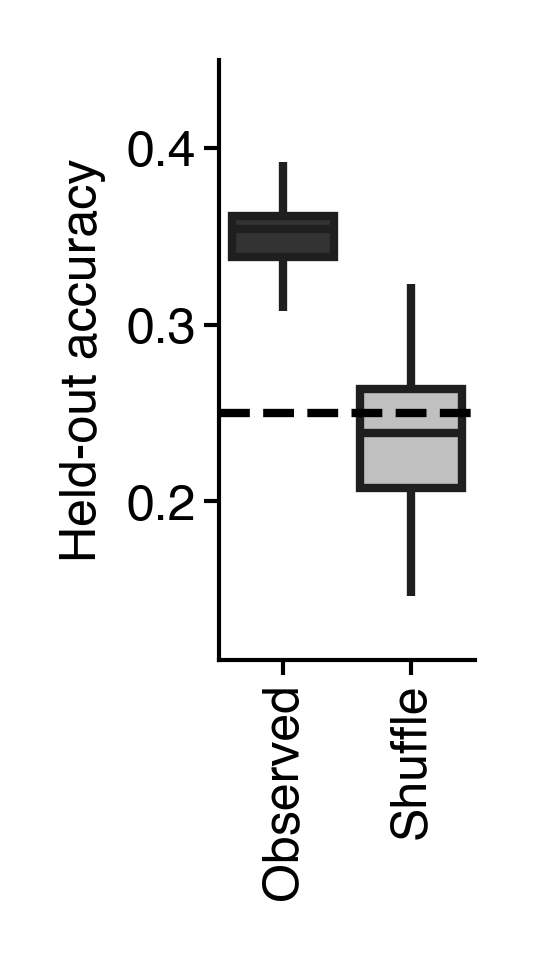

In [103]:
subset = make_death_df(tmp_df.reset_index(), 56, 71)
accs, shuffs = fit_classifier(subset)
plot_model(accs, shuffs, "tmp-death-rank-classifier-via-bambi")

In [98]:
subset[['classes', 'beh_age']].corr(method='spearman')

,classes,beh_age
classes,1.000000,-0.200176
beh_age,-0.200176,1.000000


In [99]:
subset[['death_rank', 'beh_age']].corr(method='spearman')

,death_rank,beh_age
death_rank,1.000000,-0.226917
beh_age,-0.226917,1.000000


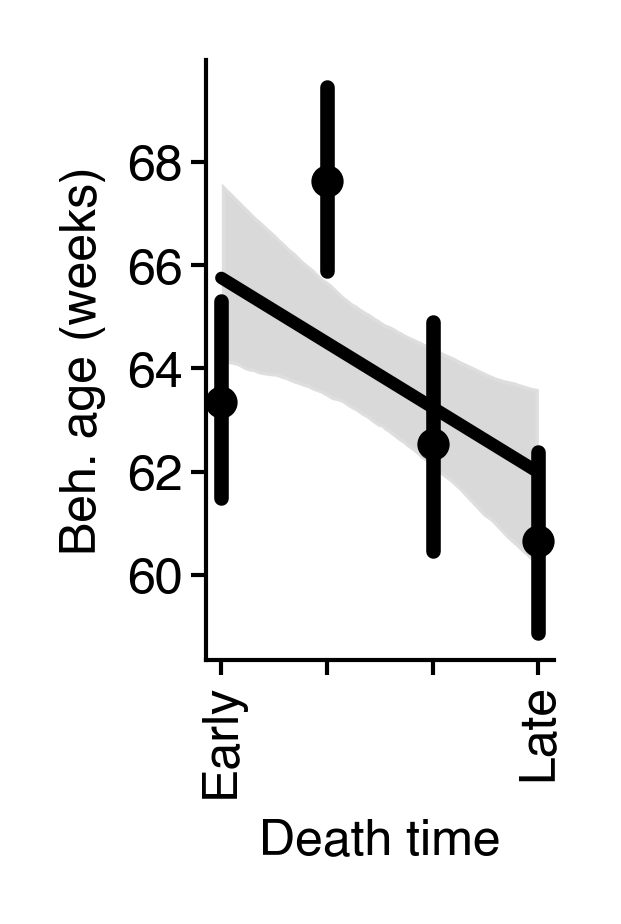

In [100]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset, x='classes', y='beh_age', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
# saver(fig, "bambi-beh-age-vs-death");

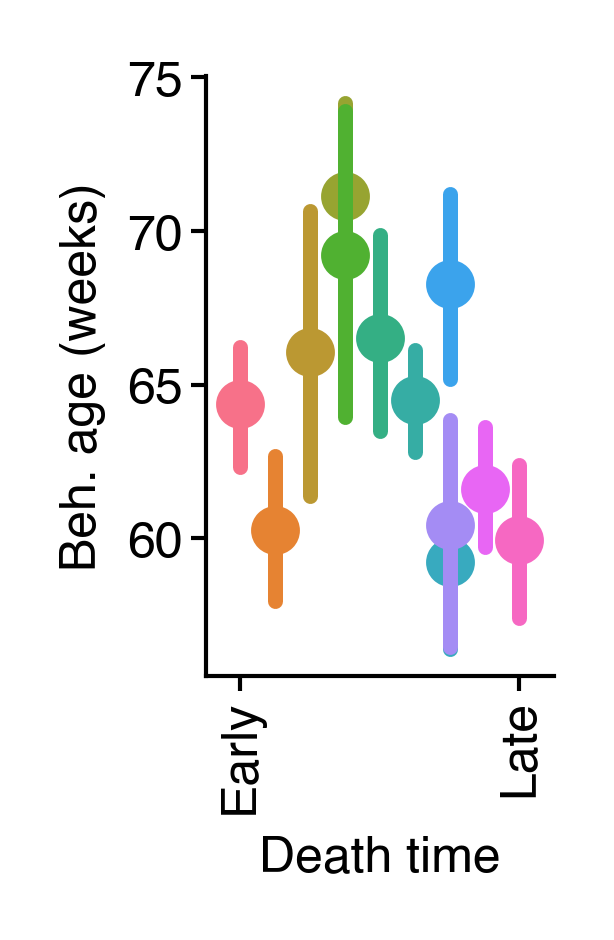

In [115]:
fig = figure(0.75, 1.3)
# ax = sns.regplot(data=subset, x='death_rank', y='beh_age', scatter=False)
# ax = sns.scatterplot(data=subset, x='death_rank', y='beh_age', hue='mouse', legend=False, s=10)
ax = sns.pointplot(data=subset, x='death_rank', y='beh_age', hue='mouse', legend=False)

# ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[3, 15], xticklabels=['Early', 'Late'])
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 8], xticklabels=['Early', 'Late'], xlim=(-1, 9))
ax.tick_params(axis='x', rotation=90)
sns.despine()
# saver(fig, "bambi-beh-age-vs-death");
